In [9]:
#HIDE
%%capture

# @title Loading libraries and setting up drive
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/Explainable-AI'

# Import the necessary packages
import io
import pandas as pd
import numpy as np
import os
import glob
import random
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, CSVLogger
from IPython.display import display
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
import copy
from graphviz import Digraph
from IPython.display import Javascript, HTML, Image, display, SVG
import copy
from scipy.ndimage import rotate
import requests
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.image as mpimg

from pathlib import Path

import plotly.io as pio
pio.renderers.default = "notebook_connected"

retrain_model = False  # ← Change to True when you want to retrain
rerun_example = False  # ← Change to True when you want to rerun the example
push_git = False # <- Change this to True when you wan to push the changes

image_base = Path('/content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics')
MRI_base = Path('/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI')
tumor_model_base = Path('/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models')

# Explainable AI

## Nutshell
In this project I use DataRobot to predict the type of food from images, as explained on the course *Modern Artificial Intelligence*, lectured by Dr. Ryan Ahmed, Ph.D. MBA. DataRobot is an end-to-end enterprise AI platform that automates and accelerates every step from data to value.

## Data
The original dataset from https://www.kaggle.com/vermaavi/food11 consists of 16643 color images belonging to 11 categories. Due to data limitations I will use pictures from 4 classes only:
1. Dessert
2. Seafood
3. Fried food
4. Vegetable-Fruit

## Grad-CAM visualization
Gradient-Weighted Class Activation Mapping (Grad-CAM) makes it possible to visualize the regions of the input that contributed towards making prediction by the model. It does so by using the class- specific gradient information flowing into the final convolutional layer of CNN to localize the important regions in the image that resulted in predicting that particular class.

### Steps
- To visualize the activation maps, first the image has to be passed through the model to make the prediction. Using argmax find the index corresponding to the maximum value in the prediction - this is the predicted class.
- Next, the gradient that is used to arrive to the predicted class from the feature map activations A^k is calculated.

$$ \alpha = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$
where
$$\frac{1}{Z} \sum_i = \text{global average pooling}$$
$$\frac{\partial y^c}{\partial A^k_{ij}} = \text{gradients via backdrop}$$

- To enhance the filter values that resulted in this prediction, the values are multiplied with tensorflow.GradientTape() with the filter values in the last convolutional layer.
- This enhances the filter values that contributed towards making this prediction and lower the filter values that didn't contribute.
- Then, the weighted combination of activation maps is performed and followed by ReLU to obtain the heatmap.

 $$ L^c_{Grad-CAM}= ReLU(\sum \alpha^c_kA^k) $$
 where

Finally, the feature heatmap is super-imposed on the original image to see the activation locations in the image.



In [2]:
#HIDE
palette = [
    "#c7522a", "#e5c185", "#f0daa5", "#fbf2c4",
    "#b8cdab", "#74a892", "#008585", "#004343"
]
grey = "#e9ecef"
kp_color="#c7522a"
legend_bg = "#272b30"

palette_hex = {"InputLayer": "#ffaa00",
    "ZeroPadding2D":"#e9854f",
    "Conv2D": "#8ECAE6",
    "BatchNormalization": "#219EBC",
    "Activation": "#023047",
    "ReLU": "#993461",
    "Add": "#126782",
    "MaxPooling2D": "#f09135",
    "AveragePooling2D": "#f09135",
    "Flatten": "#bd5665",
    "Dense": "#993461",
    "Dropout": "#692161"}

In [3]:
#HIDE
import matplotlib as mpl

mpl.rcParams.update({
    # text
    "text.color": grey,
    "axes.labelcolor": grey,
    "axes.titlecolor": grey,
    "xtick.color": grey,
    "ytick.color": grey,

    # axes / spines / grid
    "axes.edgecolor": grey,
    "grid.color": grey,

    # legend
    "legend.labelcolor": grey,
    "legend.facecolor": legend_bg,
    "legend.edgecolor": "none",

    # Transparent backgrounds everywhere
    "figure.facecolor": "none",
    "axes.facecolor": "none",
    "savefig.facecolor": "none",
    "savefig.transparent": True,
})


The best performing model for this task was Regularized Logistic Regression (L2).


<div style="text-align:left">
  <table style="border-collapse:collapse; margin-left:0; margin-right:auto;">
    <tr><th style="border-bottom:1px solid #000; padding:4px;">Metric</th>
        <th style="border-bottom:1px solid #000; padding:4px;">Validation</th>
        <th style="border-bottom:1px solid #000; padding:4px;">Cross-validation</th>
        <th style="border-bottom:1px solid #000; padding:4px;">Holdout</th></tr>
    <tr><td style="padding:4px;">AUC</td><td style="padding:4px;">0.9788</td><td style="padding:4px;">0.9877</td><td style="padding:4px;">0.9822</td></tr>
    <tr><td style="padding:4px;">Accuracy</td><td style="padding:4px;">0.8900</td><td style="padding:4px;">0.9188</td><td style="padding:4px;">0.9036</td></tr>
    <tr><td style="padding:4px;">Balanced Accuracy</td><td style="padding:4px;">0.8885</td><td style="padding:4px;">0.9196</td><td style="padding:4px;">0.9045</td></tr>
    <tr><td style="padding:4px;">FVE Multinomial</td><td style="padding:4px;">0.7699</td><td style="padding:4px;">0.8202</td><td style="padding:4px;">0.7815</td></tr>
    <tr><td style="padding:4px;">LogLoss</td><td style="padding:4px;">0.3188</td><td style="padding:4px;">0.2475</td><td style="padding:4px;">0.3019</td></tr>
  </table>
</div>

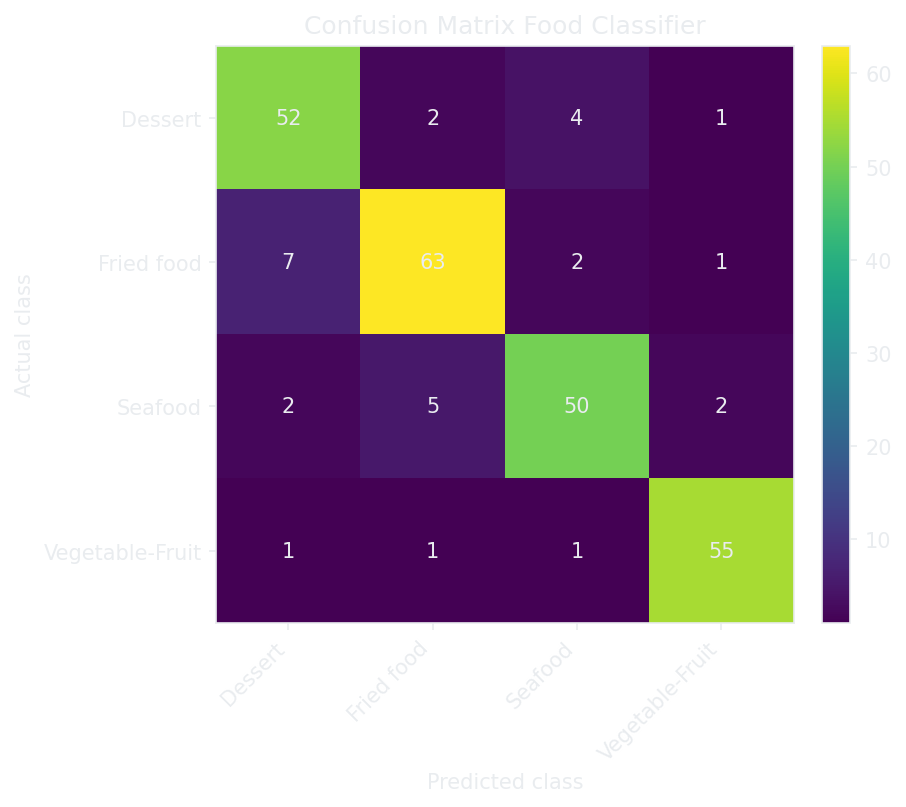

In [ ]:
#HIDE
# @title Food AI Confusion Matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv(image_base/"Confusion_matrix.csv")

actual_col = "Actual Class"
pred_col = "Predicted Class"
count_col = "Confusion Matrix Count"

# Preserve class order (order of appearance)
classes = pd.unique(pd.concat([df[actual_col], df[pred_col]], ignore_index=True))
classes = [c for c in classes if pd.notna(c)]

# Pivot long -> matrix
cm_df = (
    df.pivot_table(index=actual_col, columns=pred_col, values=count_col, aggfunc="sum", fill_value=0)
    .reindex(index=classes, columns=classes, fill_value=0)
)
cm = cm_df.to_numpy()

# ---- Plot: counts ----
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

ax.set_title("Confusion Matrix Food Classifier")
ax.set_xlabel("Predicted class")
ax.set_ylabel("Actual class")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{int(cm[i, j])}", ha="center", va="center")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
out_path = image_base/"food_cmat.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename = out_path,width=450))


Below is an example from the DataRobot models attention maps.

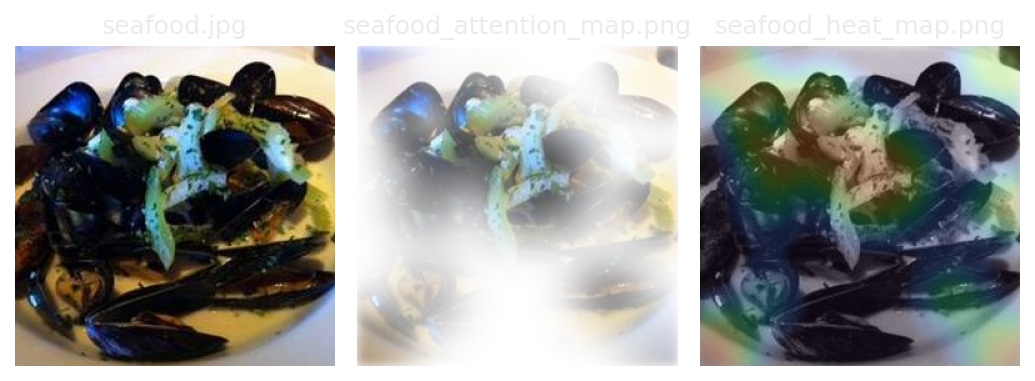

In [ ]:
#HIDE
paths = [
    image_base / "seafood.jpg",
    image_base / "seafood_attention_map.png",
    image_base / "seafood_heat_map.png",
]

fig, axes = plt.subplots(1, 3, figsize=(7,5))

for ax, p in zip(axes, paths):
    ax.imshow(mpimg.imread(p))
    ax.set_title(p.name)
    ax.axis("off")

plt.tight_layout()

out_path = image_base/"seafood_grid.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename = out_path,width=600))

In [ ]:
#HIDE
%%capture
%cd '/content/drive/MyDrive/Colab Notebooks/Explainable-AI/Data'

# Applying a Grad-CAM for the Brain tumor detector classifier model

Next I will implement a Grad-CAM pipeline for the model built in my other project. This model takes MRI images of the brain as input and classifies them into two classes: contains a brain tumor or not. You can check the project here: [Brain tumor detector](https://kaisuh.github.io/brain-tumor-detector/)

In [ ]:

#HIDE
%%capture
%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'

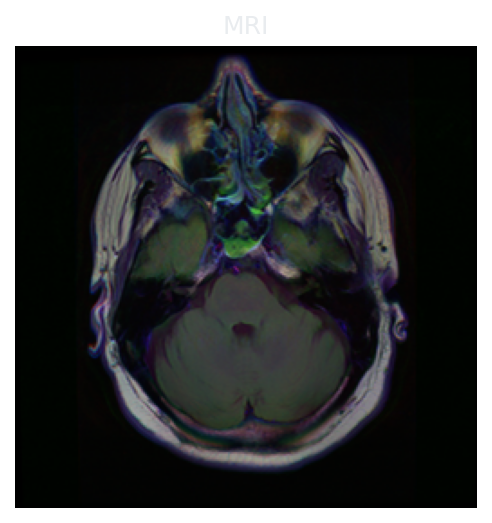

In [4]:
#HIDE
# @title MRI scan
brain_df = pd.read_csv(MRI_base/"data_mask.csv")

img_bgr = cv2.imread(MRI_base/brain_df.image_path[624])
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(4, 4))
fig.patch.set_alpha(0)     # transparent figure bg
ax.set_facecolor("none")   # transparent axes bg

ax.imshow(img_rgb)
ax.set_title("MRI")
ax.axis("off")


out_path = image_base/"mri_mask_example.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename = out_path,width=400))

# Introduction to the Brain Tumor Detection

Deep learning has proven to be as good and even better than humans in detecting diseases from X-rays, MRI scans and CT scans. there is huge potential in using AI to speed up and improve the accuracy of diagnosis.
This project will use the labeled dataset from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation which consists of 3929 Brain MRI scans and the tumor location.
The final pipeline has a two step process where
1. A **Resnet deep learning classifier model** will classify the input images into two groups: tumor detected and tumor not detected.
2. For the images, where tumor was detected, a second step is performed, where a **ResUNet segmentation model** detects the tumor location on the pixel level.


Below is an exmaple of an MRI image and the matching mask. This example has a small tumor. In images where no tumor is present, the mask will be complety black.

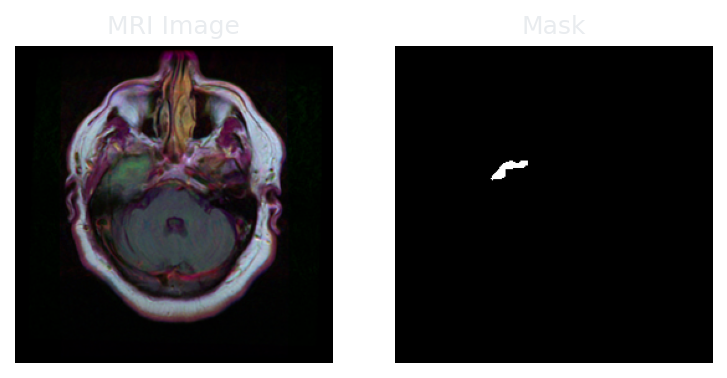

In [5]:
#HIDE

mask = MRI_base/brain_df.mask_path[623]

img = MRI_base/brain_df.image_path[623]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fig.patch.set_alpha(0)     # transparent figure bg
ax.set_facecolor("none")   # transparent axes bg

axes[0].imshow(cv2.imread(img))
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(cv2.imread(mask), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")


out_path = image_base/"mri_mask_example.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename = out_path,width=500))

## Convolutional neural networks (CNNs)
- The first CNN layers are used to extract high level general features
- The last couple of layers will perform classification
- Locla respective fields scan the image first searching for simple shapes such as edges and lines
- The edges are picked up by the subsequent layer to form more complex features

A good visualisation of the feature extraction with convolutions can be found at https://setosa.io/ev/image-kernels/





## ResNet (Residual Network)
- As CNNs grow deeper, vanishing gradients negatively imapct the network performance. Vanishing gradient occurs when the gradient is backpropagated to earlier layers which results in a very small gradient.
- ResNets "skip connection" feature can allow training of 152 layers wihtout vanishing gradient problems
- ResNet adds "identity mapping on top of the CNN
- ResNet deep network is trained with ImageNet, which contains 11 million images and 11 000 categories

ResNet paper (He etal, 2015): https://arxiv.org/pdf/1512.03385

As seen in the Figure 6. from the Resnet paper, the ResNet architectures overcome the training challenges from deep networks compared ot the plain networks. ResNet-152 achieved 3.58% error rate on the ImageNet dataset. This is better than human performance.

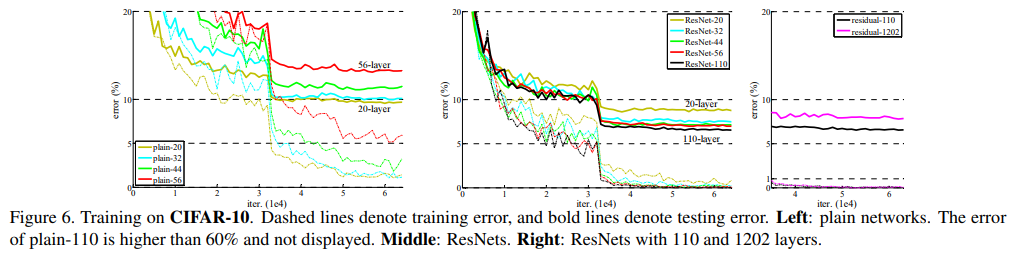

In [ ]:
#HIDE
image_path = image_base / 'resnetwork.png'
display(Image(filename=image_path))

In [6]:
#HIDE
%%capture
# @title Train test split
#Drop the patient_id (we don't need it)
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.head(0)
brain_df_train.info()

#convert the data in mask column into a string format, to use categorical mode
#in flow_fom_dataframe. Otherwise we get TypeError
brain_df_train['mask'] = brain_df_train['mask'].astype(str)
brain_df_train.info()
train, test = train_test_split(brain_df_train, test_size=0.15, random_state = 42)

In [7]:
#HIDE
# @title Image generator

#create a data generator which scales the data from 0 to 1 and makes validation
#dividing with 255 normalises the vaues which are between 0 and 255
#split of 0.15
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)



In [8]:
#HIDE
# @title Preparing image generators
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = MRI_base,
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size =16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)
valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = MRI_base,
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)
#create a data generator for test images
#no need for splitting again because here we use the "test" data set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    directory = MRI_base,
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [11]:
#HIDE
# @title Load the trained brain tumor model
# 1) Load the saved model
model = load_model(tumor_model_base/"classifier-resnet-weights_22-12-2025.keras")

# (Optional) verify it’s really loaded
model.summary()

In [12]:
#HIDE
# @title Use model for inference
make_predictions = True
if make_predictions:
  predictions = model.predict(test_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



37/37 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step


## Assessment of the model

In [13]:

#HIDE
# @title Model accuracy
y_pred = []
for i in predictions:
  y_pred.append(str(np.argmax(i)))
y_pred = np.array(y_pred)
y_true = np.asarray(test['mask'])[:len(predictions)]
print('The model accuracy is {:.2f}'.format(accuracy_score(y_true, y_pred)))

The model accuracy is 0.94


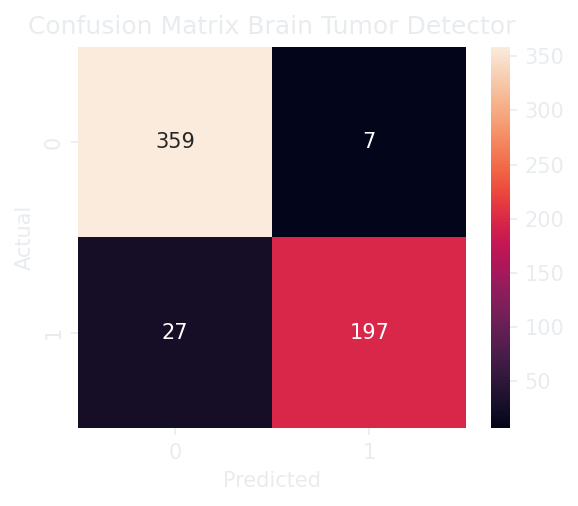

In [14]:
#HIDE
# @title Brain tumor confusion matrix
cmat = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(4, 3.5))
fig.patch.set_alpha(0)        # transparent figure background
ax.set_facecolor("none")      # transparent axes background

sns.heatmap(cmat, annot=True, fmt="g", ax=ax, cbar=True)

ax.set_title("Confusion Matrix Brain Tumor Detector", color="#e9ecef")
ax.set_xlabel("Predicted", color="#e9ecef")
ax.set_ylabel("Actual", color="#e9ecef")
ax.tick_params(colors="#e9ecef")

plt.tight_layout()

out_path = image_base/"brain_cmat.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename = out_path,width=350))

In [15]:
#HIDE
# @title Brain tumor detector classification report
print("Classification report")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels = [0,1]))

Classification report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       366
           1       0.97      0.88      0.92       224

   micro avg       0.94      0.94      0.94       590
   macro avg       0.95      0.93      0.94       590
weighted avg       0.94      0.94      0.94       590



## Grad-CAM for the Brain tumor detector model

In [51]:
#HIDE
# @title Helper functions fo single layer plotting
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path


def overlay_red_mask_on_image(img_rgb, mask_gray, alpha=0.45, thresh=1):
    """
    img_rgb: (H,W,3) uint8
    mask_gray: (H,W) uint8 or bool (same H,W as img_rgb)
    alpha: transparency of the red overlay
    """
    mask_bin = (mask_gray >= thresh)
    out = img_rgb.copy()

    # red overlay only where mask is 1
    red = np.zeros_like(out)
    red[..., 0] = 255  # R channel

    out[mask_bin] = (out[mask_bin] * (1 - alpha) + red[mask_bin] * alpha).astype(np.uint8)
    return out

def _load_img_for_model(image_path, target_size=(256, 256)):
    """Loads an image from disk and formats it as (1,H,W,3) float32 in [0,1]."""
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img_array = img_resized.astype(np.float32) / 255.0
    return img_resized, np.expand_dims(img_array, axis=0)

def _conv_layer_names(model):
    """Returns the name of a Conv2D layer"""
    return [l.name for l in model.layers if isinstance(l, keras.layers.Conv2D)]


def _find_last_conv_layer_name(model):
    """Find the last Conv2D-like layer name (works for most CNNs)."""
    for layer in reversed(model.layers):
        if isinstance(layer, keras.layers.Conv2D):
            return layer.name
    # fallback: any layer with 4D output (batch,h,w,channels)
    for layer in reversed(model.layers):
        try:
            shape = layer.output_shape
            if isinstance(shape, tuple) and len(shape) == 4:
                return layer.name
        except Exception:
            pass
    raise ValueError("Could not automatically find a suitable last conv layer.")

def make_gradcam_attention_map(img_array, model, last_conv_layer_name=None, pred_index=None):
    """
    Returns (attention_map, predicted_class_index, predicted_vector).
    - attention_map is a 2D float array normalized to [0,1].
    """
    if last_conv_layer_name is None:
        last_conv_layer_name = _find_last_conv_layer_name(model)

    # Build a model that maps input -> (last conv activations, model output)
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model =  tf.keras.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)

        # Decide which class to explain:
        # - sigmoid/binary: preds shape (1,1) -> use that scalar
        # - softmax: preds shape (1,C) -> argmax if pred_index not given
        preds_np = preds.numpy()
        if pred_index is None:
            if preds_np.ndim == 2 and preds_np.shape[1] > 1:
                pred_index = int(np.argmax(preds_np[0]))
            else:
                pred_index = 0  # single logit/sigmoid

        if preds_np.ndim == 2 and preds_np.shape[1] > 1:
            class_channel = preds[:, pred_index]
        else:
            class_channel = preds[:, 0]

    # Gradient of the class score w.r.t. conv feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling over spatial dimensions => importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by corresponding pooled gradients
    conv_outputs = conv_outputs[0]
    attention = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU and normalize to [0,1]
    attention = tf.maximum(attention, 0)
    max_val = tf.reduce_max(attention) + tf.keras.backend.epsilon()
    attention_map = attention / max_val

    return attention_map.numpy(), pred_index, preds_np

def show_gradcam_grid(image_path, model, last_conv_layer_name=None, alpha=0.45, out_path=None):
    """
    Displays 3 panels:
    - original
    - attention map (grayscale)
    - heatmap overlay
    Optionally saves the figure to out_path (recommended for nbconvert/GitHub Pages).
    """
    # Load image
    img_rgb, img_array = _load_img_for_model(image_path, target_size=(256, 256))

    # Grad-CAM attention map
    attn, pred_index, preds_np = make_gradcam_attention_map(
        img_array, model, last_conv_layer_name=last_conv_layer_name
    )

    # Resize attention map to image size
    attn_resized = cv2.resize(attn, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Build a color heatmap
    heatmap = (cm.jet(attn_resized)[:, :, :3] * 255).astype(np.uint8)

    # Overlay heatmap onto original
    overlay = cv2.addWeighted(img_rgb, 1.0, heatmap, alpha, 0)

    # Figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.patch.set_alpha(0)
    for ax in axs:
        ax.set_facecolor("none")
        ax.axis("off")

    # Titles (use your site-grey)
    grey = "#e9ecef"
    # prediction text
    pred_text = ""
    if preds_np.ndim == 2 and preds_np.shape[1] > 1:
        pred_text = f"pred class = {pred_index} | probs = {np.round(preds_np[0], 4)}"
    else:
        pred_text = f"pred score = {float(preds_np[0][0]):.4f}"

    axs[0].set_title("Original MRI", color=grey)
    axs[0].imshow(img_rgb)

    axs[1].set_title("Attention map (Grad-CAM)", color=grey)
    axs[1].imshow(attn_resized, cmap="gray")

    axs[2].set_title("Heatmap overlay", color=grey)
    axs[2].imshow(overlay)

    fig.suptitle(pred_text, color=grey, y=1.02, fontsize=10)
    fig.tight_layout()

    if out_path is not None:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
        plt.close(fig)
        return out_path
    else:
        plt.show()
        return None


def make_gradcam_attention_map_abs(img_array, model, last_conv_layer_name=None, pred_index=None):
    """
    Uses absolutes instead of ReLU. Better option for very low value attention maps.
    Returns (attention_map, predicted_class_index, predicted_vector).
    - attention_map is a 2D float array normalized to [0,1].
    """
    if last_conv_layer_name is None:
        last_conv_layer_name = _find_last_conv_layer_name(model)

    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model =  tf.keras.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)
        preds_np = preds.numpy()

        if pred_index is None:
            if preds_np.ndim == 2 and preds_np.shape[1] > 1:
                pred_index = int(np.argmax(preds_np[0]))
            else:
                pred_index = 0

        class_channel = preds[:, pred_index] if (preds_np.ndim == 2 and preds_np.shape[1] > 1) else preds[:, 0]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    attention = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ✅ abs instead of ReLU so you still get structure
    attention = tf.abs(attention)

    max_val = tf.reduce_max(attention) + tf.keras.backend.epsilon()
    attention_map = attention / max_val

    return attention_map.numpy(), pred_index, preds_np

def make_gradcam_attention_map_robust(
    img_array, model, last_conv_layer_name=None, pred_index=None,
    min_std=1e-6, min_max=1e-6
):
    """
    Returns attention_map, pi (predicted_class_index),
    preds_np(predicted_vector), and a variable best telling which was the better one.
    The function trys first ReLU and if that produces a black image, it will try abs.
    - attention_map is a 2D float array normalized to [0,1].
    """

    # choose ONE layer and keep it fixed
    layer_name = last_conv_layer_name or _find_last_conv_layer_name(model)

    # 1) ReLU Grad-CAM on that layer
    attn, pi, preds_np = make_gradcam_attention_map(
        img_array, model, last_conv_layer_name=layer_name, pred_index=pred_index
    )

    # if map is not "black", keep it
    if np.nanmax(attn) > min_max and np.nanstd(attn) > min_std:
        return attn, pi, preds_np, layer_name, False

    # 2) fallback: ABS Grad-CAM on the SAME layer
    attn, pi, preds_np = make_gradcam_attention_map_abs(
        img_array, model, last_conv_layer_name=layer_name, pred_index=pred_index
    )
    return attn, pi, preds_np, layer_name, True


def enhance_cam_for_display(cam, clip_percentiles=(2, 98), gamma=0.7, gain=2.0, eps=1e-8):
    """
    Display-only enhancement:
    1) percentile clip to remove outliers
    2) min-max normalize to [0,1]
    3) gamma to boost midtones
    4) gain to make faint maps visible
    """
    cam = np.nan_to_num(cam, nan=0.0, posinf=0.0, neginf=0.0)
    lo, hi = np.percentile(cam, clip_percentiles)
    cam = np.clip(cam, lo, hi)
    cam = (cam - lo) / (hi - lo + eps)
    cam = np.power(cam, gamma)
    cam = np.clip(cam * gain, 0, 1)
    return cam


Below is an example from the grad-CAM visualisation applied to the brain tumor image classifier model.

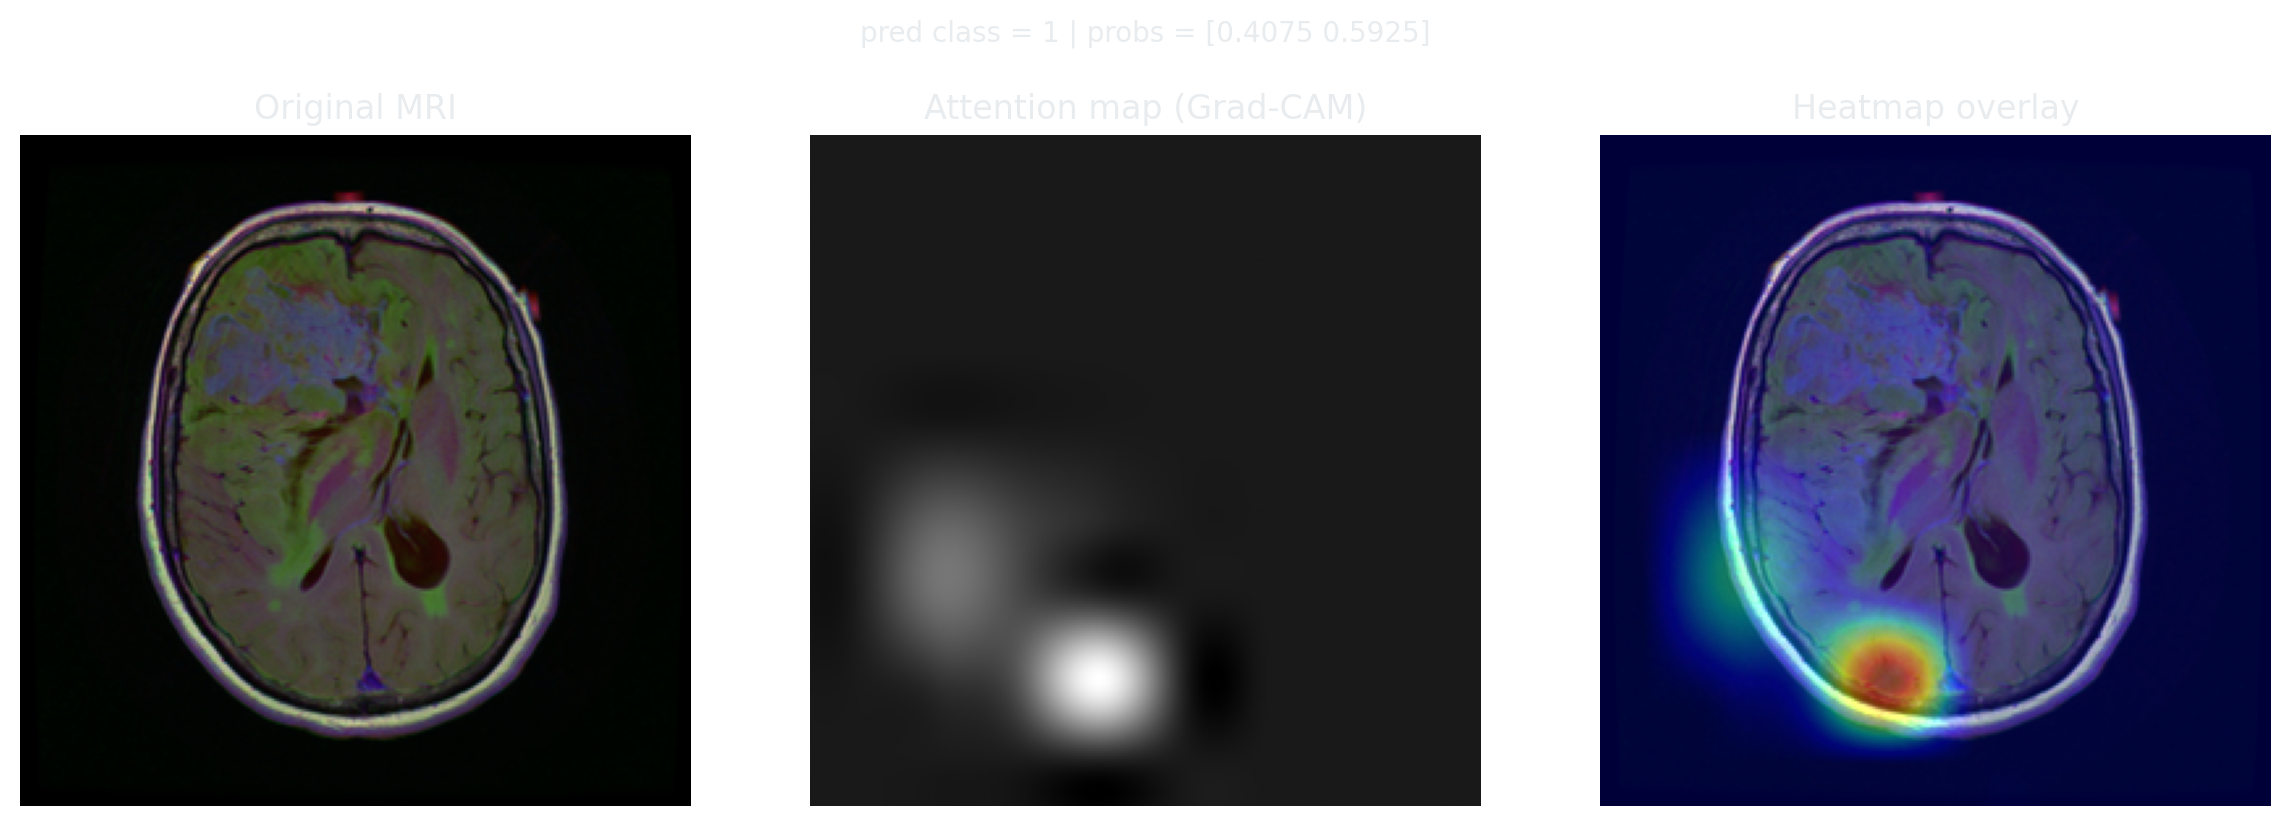

In [52]:
#HIDE
# Example: pick first image that your pipeline marked as having a tumor

# Find all indices where y_pred is '1' (predicted as having a tumor)
tumor_predicted_indices = np.where(y_pred == '1')[0]

if len(tumor_predicted_indices) > 0:
    # Get the first index from the list of positive predictions
    row_for_display = tumor_predicted_indices[5]
    # Use this index to get the corresponding image path from the 'test' DataFrame
    image_path = MRI_base/test.iloc[row_for_display]['image_path']
else:
    # Fallback if no tumors are predicted (unlikely given the confusion matrix, but good practice)
    print("Warning: No images were predicted as having a tumor. Displaying Grad-CAM for the first image in the test set.")
    row_for_display = 0
    image_path = MRI_base/test.iloc[row_for_display]['image_path']

out_path = image_base/"gradcam_triptych.png"
saved = show_gradcam_grid(image_path, model, out_path=out_path)

from IPython.display import Image, display
display(Image(filename=saved, width=900))

In the grid below we see that the attention map is corresponding well with the clinicians mask - eventhough the classifier has never seen or beentrained on the mask.

This block loops over a set of test images (here: cases predicted as containing tumor), loading each MRI slice and its ground-truth mask (if available), and then computing a Grad-CAM attention map for the classifier’s decision. The Grad-CAM attention map is contrast-enhanced for visibility. I chose to look further “in” than the very last convolutional layer (via the robust layer selection) because the final conv features can become too coarse or gradient-saturated, producing weak or even blank maps; earlier convolutional layers often preserve more spatial detail and yield attention maps that align better with the actual tumor region, making the explanation more informative and easier to interpret.

In [53]:
#HIDE
# @title Functions for Grad-CAM
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm
from IPython.display import Image, display
test
def show_gradcam_grid_with_masks(
    test,
    model,
    y_pred,
    n_cases=8,
    n_cols=2,
    MRI_base=MRI_base,
    grad_cam_setup = 'robust',
    enhance=True,
    out_path=image_base/"gradcam_grid_with_masks.png",
    last_conv_layer_name=None,
    alpha=0.45,
):
    """This function plots one layer of the network with the grad-CAM attetnion map
    and heat map. It also displays the original image and the original image with an overlayed
    mask in red (the truth)."""

    # pick a ground-truth column for mask presence (0/1)
    if "mask" in test.columns:
        true_col = "mask"
    else:
        true_col = None  # fallback

    # indices (keep your original behavior: select predicted tumors)
    tumor_predicted_indices = np.where(np.array(y_pred).astype(str) == "1")[0]
    if len(tumor_predicted_indices) == 0:
        print("Warning: No images predicted as tumor. Using first n_cases images.")
        tumor_predicted_indices = np.arange(min(n_cases, len(test)))

    chosen = tumor_predicted_indices[:n_cases]
    n_cases = len(chosen)

    cases_per_row = n_cols
    n_rows = int(np.ceil(n_cases / cases_per_row))

    fig, axs = plt.subplots(
        n_rows, cases_per_row * 4,
        figsize=(cases_per_row * 2.1 * 4, n_rows * 2.5),
    )
    fig.patch.set_alpha(0)
    axs = np.atleast_2d(axs)

    grey = "#e9ecef"

    for idx_in_grid, row_for_display in enumerate(chosen):
        r = idx_in_grid // cases_per_row
        c0 = (idx_in_grid % cases_per_row) * 4

        image_path = MRI_base/test.iloc[row_for_display]["image_path"]

        # ---- predicted / true info ----
        pred_val = 1 if str(y_pred[row_for_display]) == "1" else 0
        pred_text = "Tumor" if pred_val == 1 else "No tumor"

        if true_col is not None:
            true_val = int(test.iloc[row_for_display][true_col])
        else:
            true_val = -1  # unknown

        # --- load original image (RGB) ---
        img_bgr = cv2.imread(str(image_path))
        if img_bgr is None:
            for k in range(4):
                axs[r, c0 + k].axis("off")
                axs[r, c0 + k].set_title("Missing image", color=grey)
            continue

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb_256 = cv2.resize(img_rgb, (256, 256), interpolation=cv2.INTER_AREA)

        # ---- Panel 1: MRI ----
        ax = axs[r, c0 + 0]
        ax.set_facecolor("none")
        ax.imshow(img_rgb_256)
        ax.set_title(
            f"Case {idx_in_grid+1}\nPred: {pred_text} ({pred_val}) | True class: {true_val}",
            color=grey, fontsize=10
        )
        ax.axis("off")

        # --- load mask image (optional) ---
        mask_original_256 = None
        if "mask_path" in test.columns and pd.notna(test.iloc[row_for_display].get("mask_path", None)):
            mask_path = MRI_base/test.iloc[row_for_display]["mask_path"]
            mask_original = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask_original is not None:
                mask_original_256 = cv2.resize(mask_original, (256, 256), interpolation=cv2.INTER_NEAREST)
        ax = axs[r, c0 + 1]
        ax.set_facecolor("none")

        # ---- Panel 2: Mask overlay (red) ----
        if mask_original_256 is None:
            ax.text(0.5, 0.5, "No mask image\navailable",
                    ha="center", va="center", color=grey, fontsize=10)
            ax.imshow(img_rgb_256)  # still show the image so the column isn't empty
        else:
            mask_overlay = overlay_red_mask_on_image(img_rgb_256, mask_original_256, alpha=0.75, thresh=1)
            ax.imshow(mask_overlay)

        ax.set_title("Mask overlay (red)", color=grey, fontsize=10)
        ax.axis("off")

        # --- grad-cam attention ---
        _, img_array = _load_img_for_model(image_path, target_size=(256, 256))
        if grad_cam_setup == 'robust':
          attn, pred_index, preds_np, used_layer, used_abs = make_gradcam_attention_map_robust(
            img_array, model, last_conv_layer_name=last_conv_layer_name
          )
        if grad_cam_setup == 'abs':
          attn, pred_index, preds_np = make_gradcam_attention_map_abs(
            img_array, model, last_conv_layer_name=last_conv_layer_name
          )
          used_layer = last_conv_layer_name
          used_abs = True
        if grad_cam_setup == 'regular':
          attn, pred_index, preds_np = make_gradcam_attention_map(
            img_array, model, last_conv_layer_name=last_conv_layer_name
          )
          used_layer = last_conv_layer_name
          used_abs = False
        attn_resized = cv2.resize(attn, (256, 256), interpolation=cv2.INTER_CUBIC)

        # --- If wanted enhance the dark maps ---
        if enhance == True:
          attn_disp = enhance_cam_for_display(attn_resized, clip_percentiles=(1, 99), gamma=0.7, gain=2.5)
        else:
          attn_disp = attn_resized

        # --- build a color heatmap ---
        heatmap = (cm.jet(attn_disp)[:, :, :3] * 255).astype(np.uint8)
        overlay = cv2.addWeighted(img_rgb_256, 1.0, heatmap, alpha, 0)


        # 3) attention map
        ax = axs[r, c0 + 2]
        ax.set_facecolor("none")
        ax.imshow(attn_disp, cmap="gray", vmin=0, vmax=1)
        note = "abs" if used_abs else "relu"
        axs[r, c0 + 2].set_title(f"Grad-CAM\n({note}, {used_layer})", color=grey, fontsize=10)

        ax.axis("off")

        # 4) overlay
        ax = axs[r, c0 + 3]
        ax.set_facecolor("none")
        ax.imshow(overlay)
        if preds_np.ndim == 2 and preds_np.shape[1] > 1:
            pred_info = f"class={pred_index}"
        else:
            pred_info = f"score={float(preds_np[0][0]):.3f}"
        ax.set_title(f"Overlay\n({pred_info})", color=grey, fontsize=10)
        ax.axis("off")

    # hide any unused axes
    total_axes = n_rows * cases_per_row * 4
    used_axes = n_cases * 4
    if used_axes < total_axes:
        flat = axs.ravel()
        for j in range(used_axes, total_axes):
            flat[j].axis("off")
            flat[j].set_facecolor("none")

    fig.tight_layout()
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
    plt.close(fig)
    return out_path


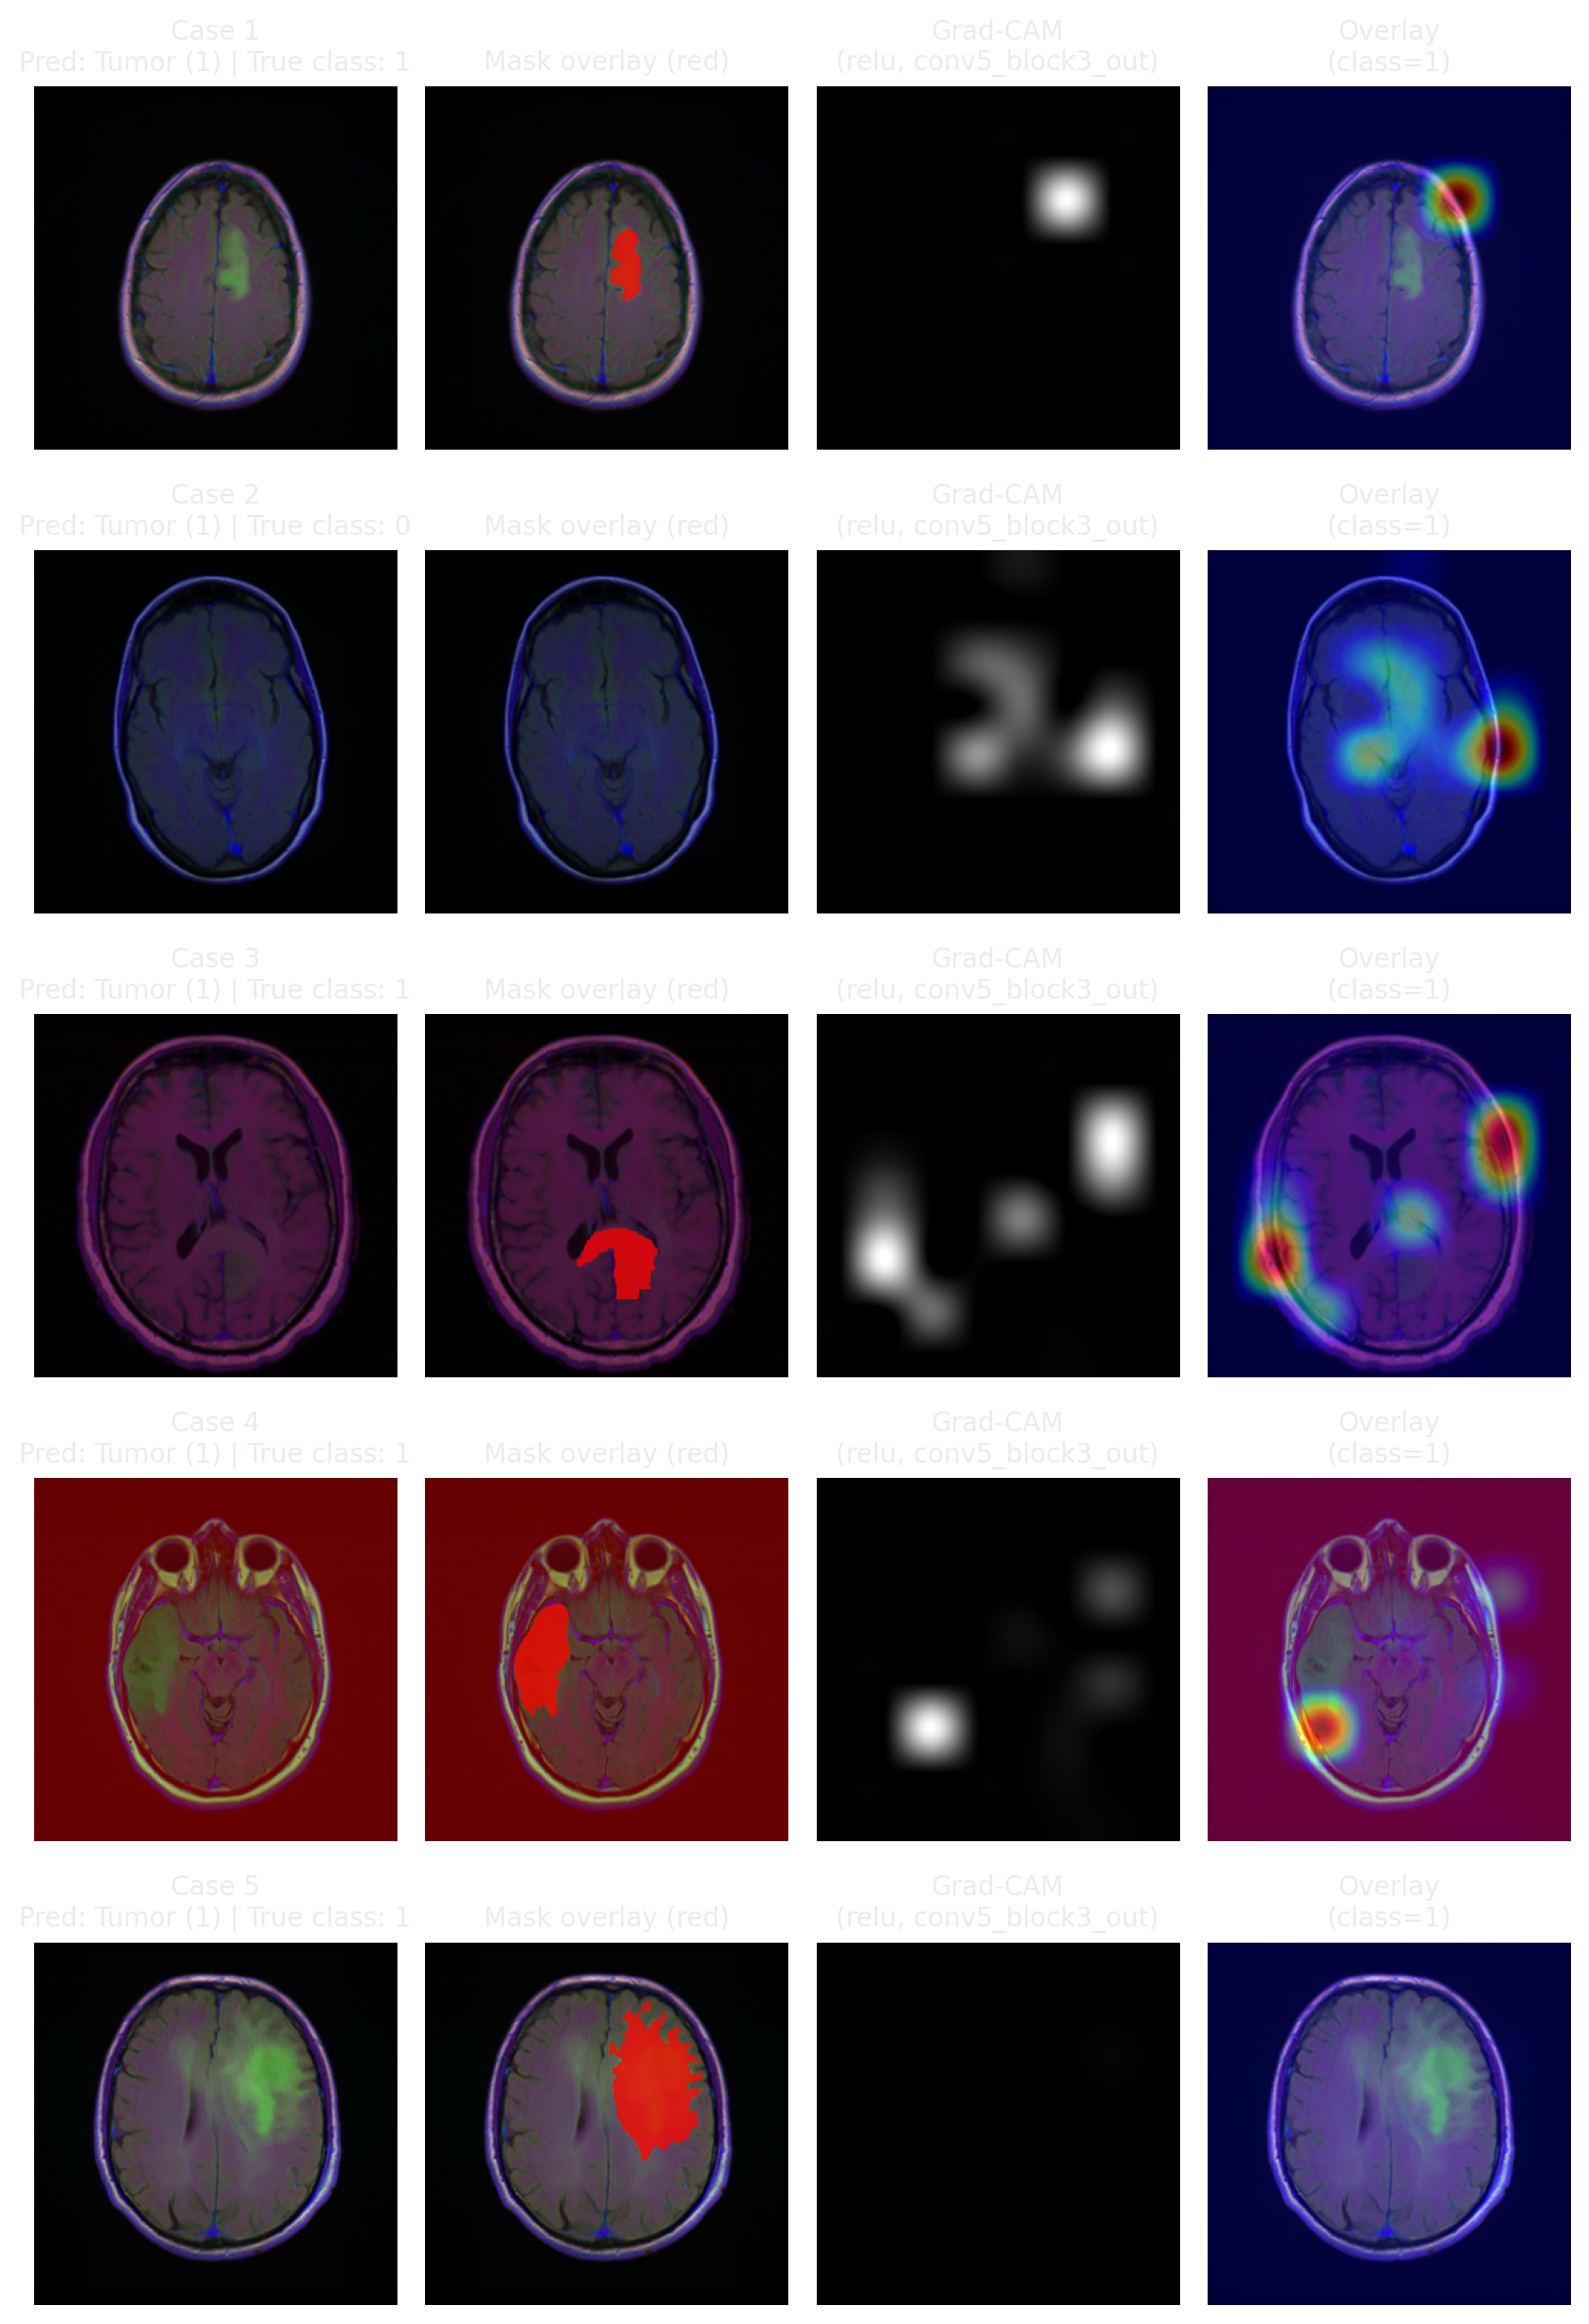

In [54]:
#HIDE
conv_l = "conv5_block3_out"

# call
out_path = show_gradcam_grid_with_masks(
    test=test,
    model=model,
    y_pred=y_pred,
    n_cases=5,
    n_cols=1,
    grad_cam_setup='robust',
    enhance=False,
    last_conv_layer_name = conv_l,
    out_path=image_base/"gradcam_grid_with_masks_1.png",
)
display(Image(filename=out_path, width=500))

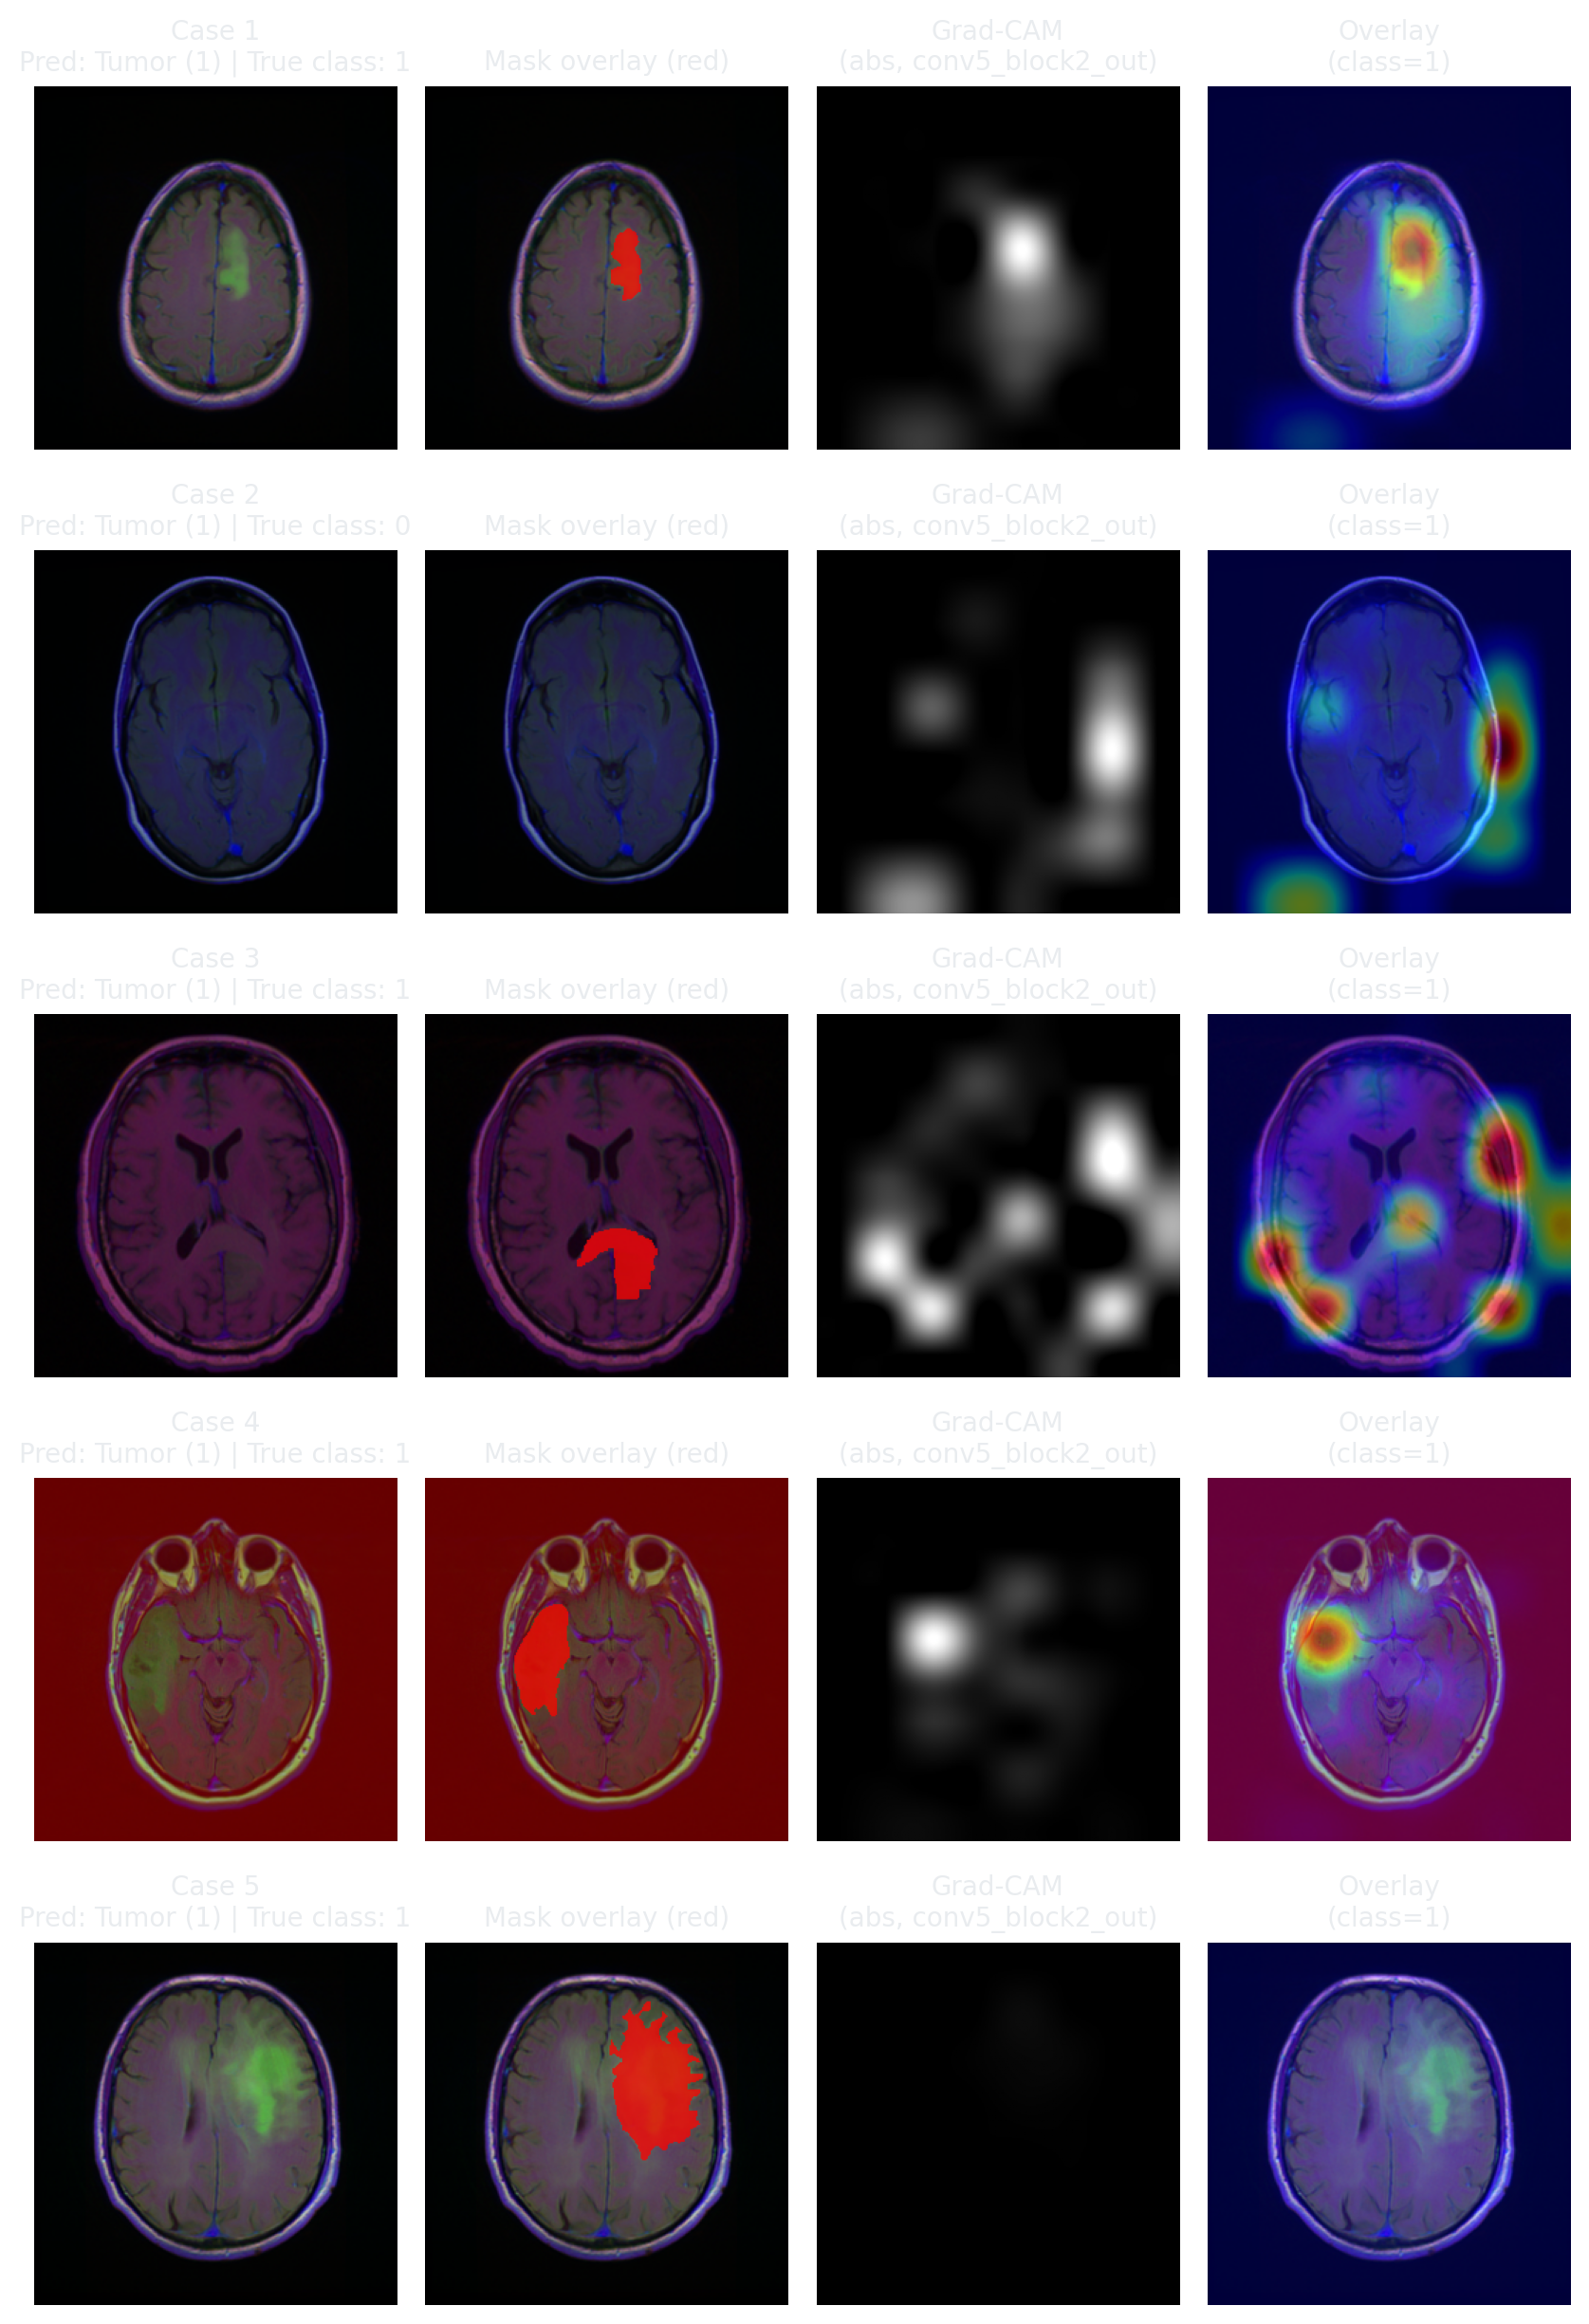

In [55]:
#HIDE
conv_l = "conv5_block2_out"

# call
out_path = show_gradcam_grid_with_masks(
    test=test,
    model=model,
    y_pred=y_pred,
    n_cases=5,
    n_cols=1,
    grad_cam_setup='abs',
    enhance=False,
    last_conv_layer_name = conv_l,
    out_path=image_base/"gradcam_grid_with_masks_2.png",
)
display(Image(filename=out_path, width=500))

In [59]:
#HIDE
# @title Helper function for looping through all of the layers
from pathlib import Path
import re
from IPython.display import Image, display

def get_4d_layers(model):
    skip_types = (
        tf.keras.layers.ZeroPadding2D,
        tf.keras.layers.MaxPooling2D,
        tf.keras.layers.BatchNormalization,
        tf.keras.layers.Add,
        tf.keras.layers.AveragePooling2D,
        tf.keras.layers.Flatten,
        tf.keras.layers.Dense,
        tf.keras.layers.Dropout,
        tf.keras.layers.ReLU,
    )

    names = []
    for layer in model.layers:
        # skip by type
        if isinstance(layer, skip_types):
            continue

        # get output shape robustly
        try:
            shape = layer.output_shape
        except Exception:
            shape = tf.keras.backend.int_shape(layer.output)

        # handle multi-output layers (list of shapes)
        if isinstance(shape, list):
            shape = shape[0]

        # TensorShape -> tuple
        if hasattr(shape, "as_list"):
            shape = tuple(shape.as_list())

        # keep only 4D outputs: (None, H, W, C)
        if shape is not None and len(shape) == 4:
            names.append(layer.name)

    return names

def get_conv2d_4d_layers(model):
    names = []
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.Conv2D):
            continue

        shape = getattr(layer, "output_shape", None) or tf.keras.backend.int_shape(layer.output)
        if isinstance(shape, list):
            shape = shape[0]
        if hasattr(shape, "as_list"):
            shape = tuple(shape.as_list())

        if shape is not None and len(shape) == 4:
            names.append(layer.name)
    return names

def _safe_name(s: str) -> str:
    # keep filenames filesystem-friendly
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", s)

def list_gradcam_candidate_layers(model, mode="4d"):
    """
    mode="4d"   -> any layer whose output is 4D (batch,H,W,C). Works for Conv/BN/ReLU blocks too.
    mode="conv" -> only Conv2D layers.
    """
    names = []

    if mode == "conv":
      layer_names= get_conv2d_4d_layers(model)
    else:
    # 4D output layers
      layer_names = get_4d_layers(model)
    return layer_names

def export_gradcam_for_all_layers(
    test,
    model,
    y_pred,
    image_base,
    n_cases=5,
    n_cols=1,
    grad_cam_setup="regular",
    enhance=False,
    mode="4d",     # "4d" or "conv"
    out_dir_name="gradcam_by_layer",
    verbose=True,
):
    """
    Loops through candidate layers and saves one Grad-CAM grid image per layer.
    Returns list of saved file paths.
    """
    out_dir = Path(image_base) / out_dir_name
    out_dir.mkdir(parents=True, exist_ok=True)

    if mode == "conv":
      layer_names= get_conv2d_4d_layers(model)
    else:
    # 4D output layers
      layer_names = get_4d_layers(model)

    saved_paths = [] # Initialize saved_paths list

    for i, lname in enumerate(layer_names, start=1):
        out_path = out_dir / f"{_safe_name(lname)}.png"
        try:
            show_gradcam_grid_with_masks(
                test=test,
                model=model,
                y_pred=y_pred,
                n_cases=n_cases,
                n_cols=n_cols,
                grad_cam_setup=grad_cam_setup,
                enhance=enhance,
                last_conv_layer_name=lname,
                out_path=out_path,
            )
            saved_paths.append(out_path)
            if verbose:
                print(f"[{i}/{len(layer_names)}] saved -> {out_path}")
        except Exception as e:
            if verbose:
                print(f"[{i}/{len(layer_names)}] skipped {lname}: {e}")

    return saved_paths # Return the list of saved paths


[1/103] skipped input_layer: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
[2/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv1_conv.png
[3/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv1_relu.png
[4/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv2_block1_1_conv.png
[5/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv2_block1_1_relu.png
[6/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv2_block1_2_conv.png
[7/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv2_block1_2_relu.png
[8/103] saved -> /content/drive/MyDrive/Colab Notebooks/Explainable-AI/docs/pics/gradcam_by_layer/conv2_block1_0_conv.png
[9/103] saved -> /content/drive/MyDrive/Co

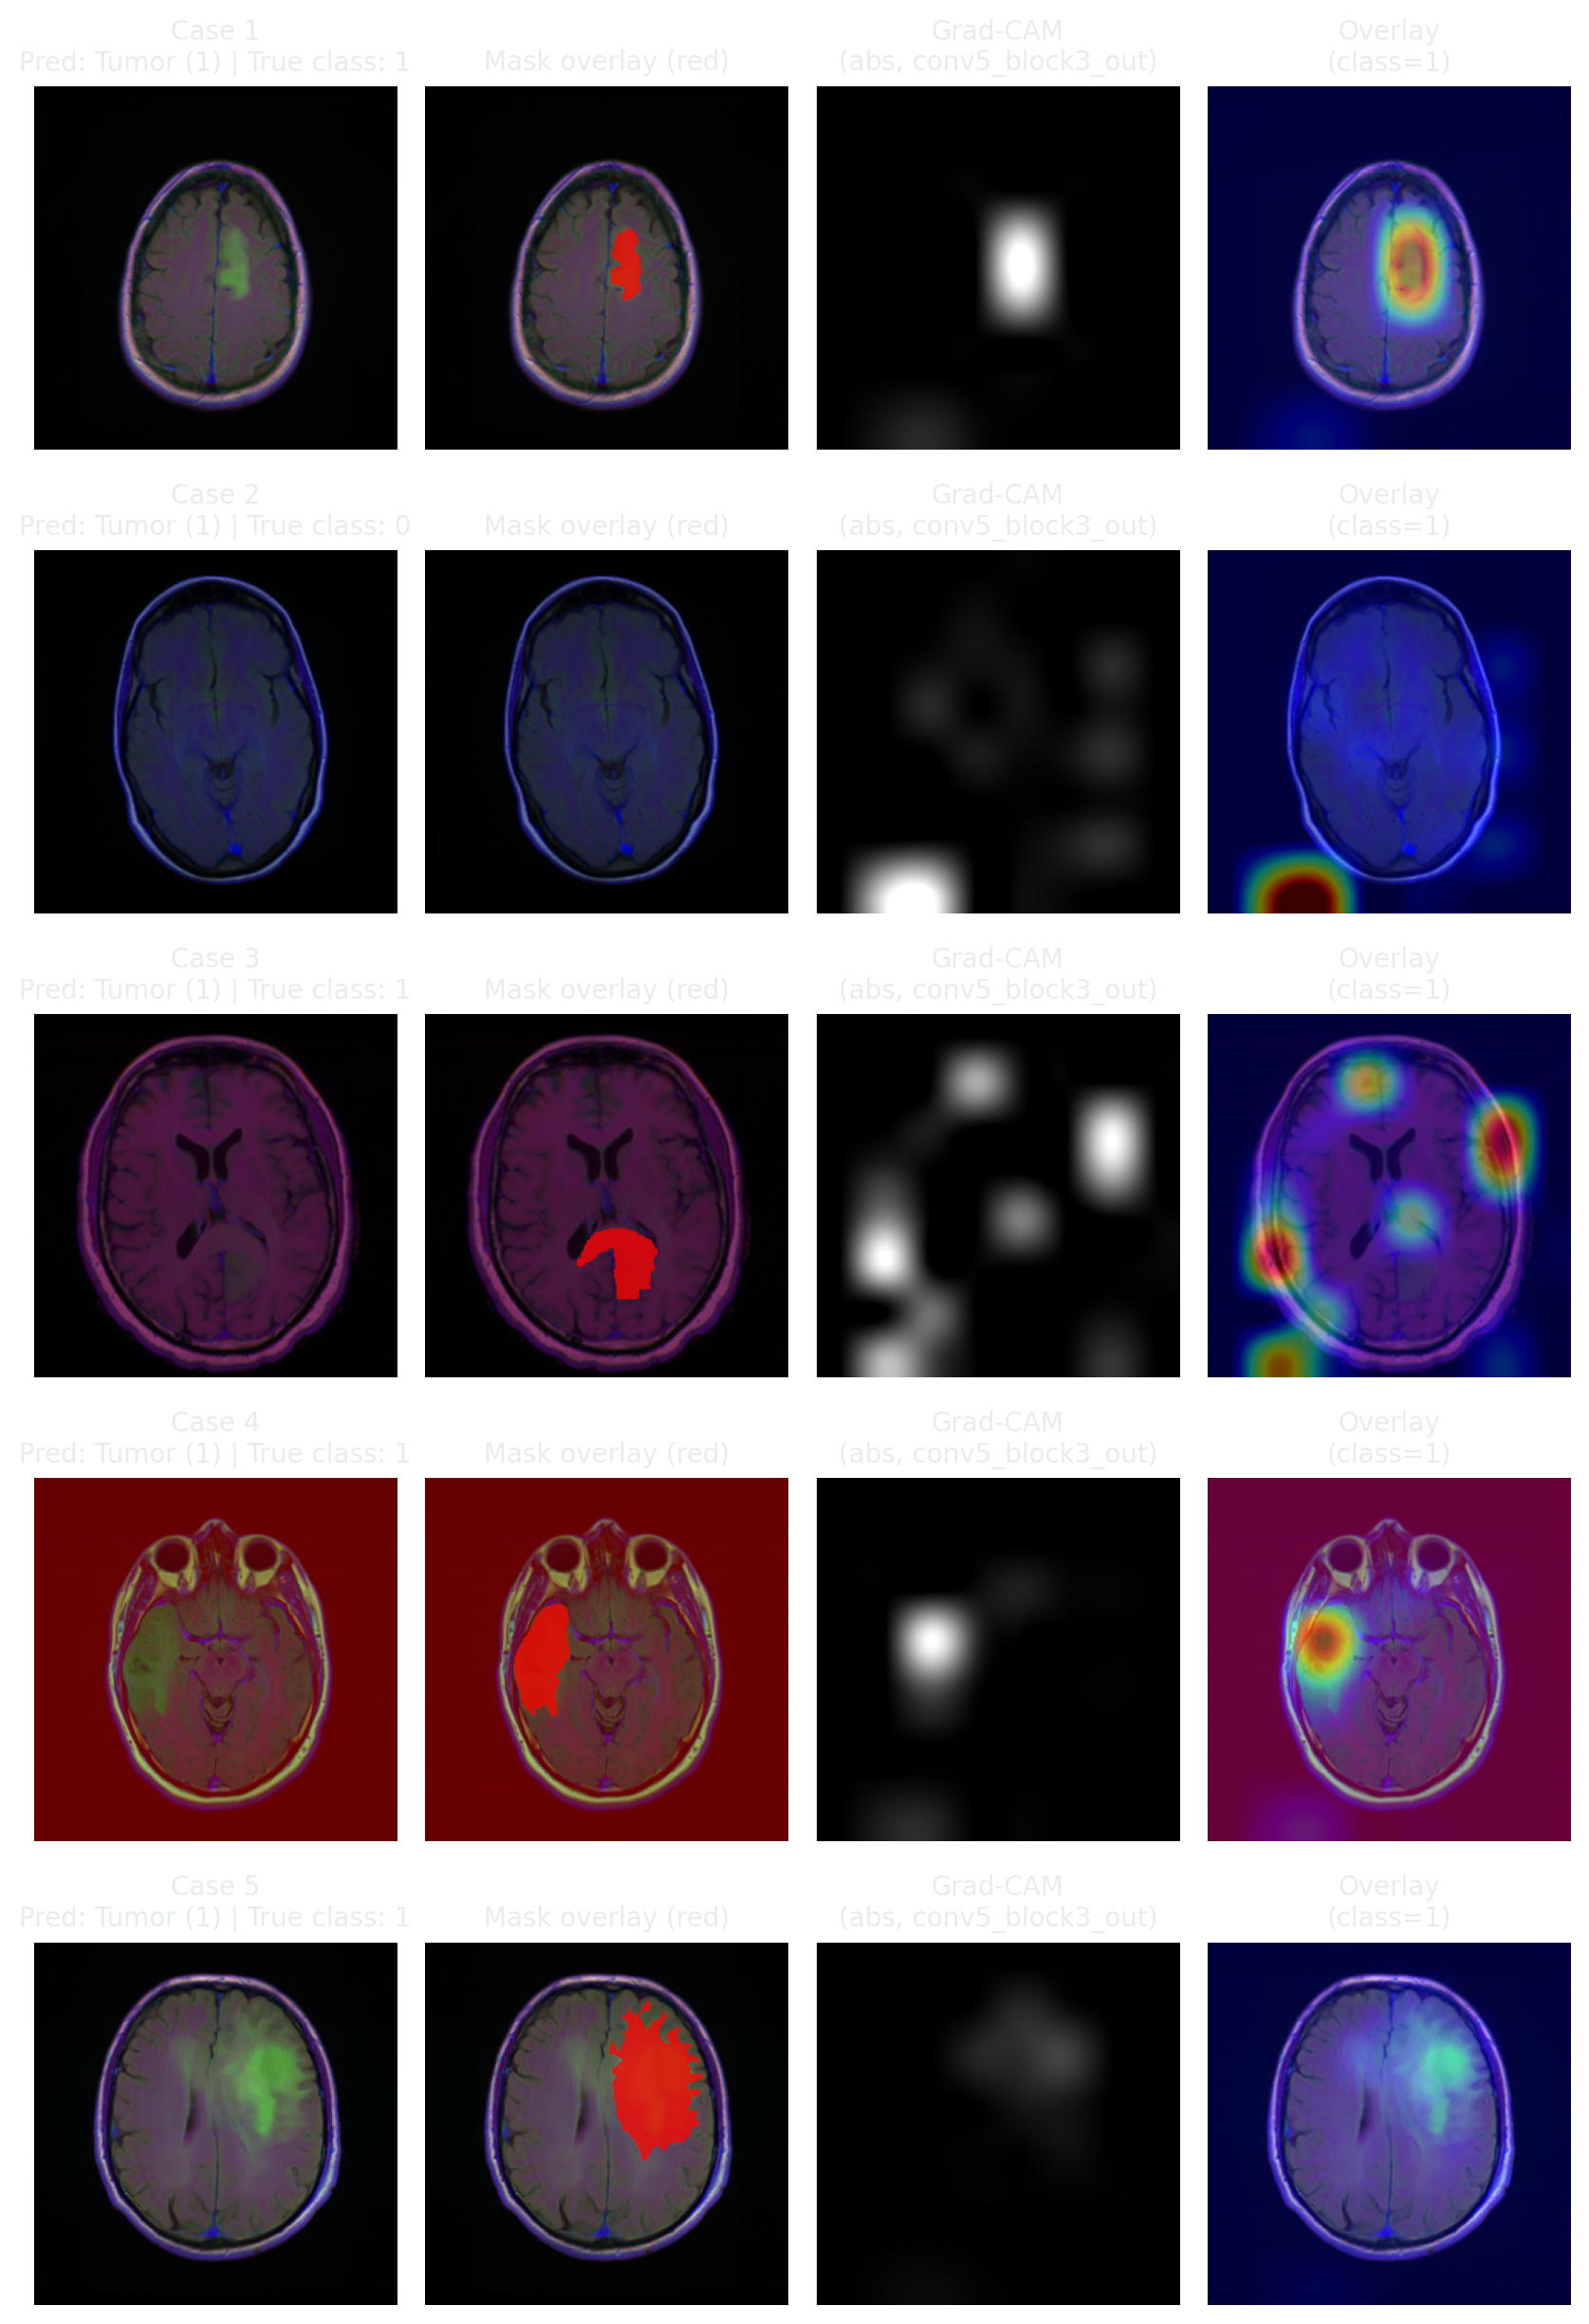

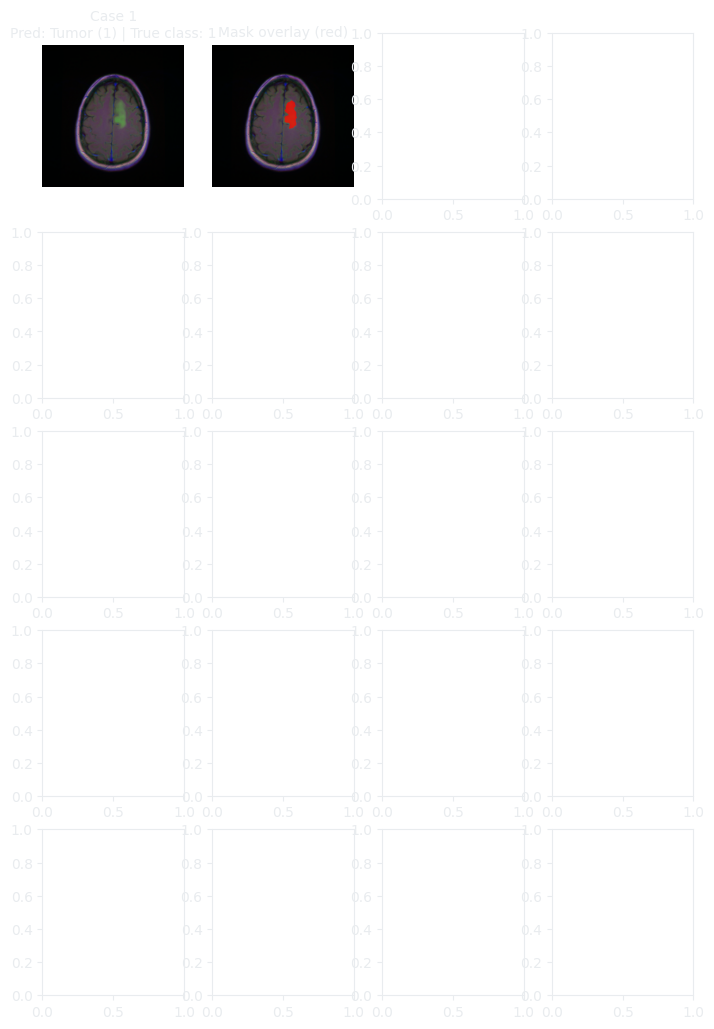

In [60]:
#HIDE
# @title Creating an image for all layers
# ---- run (this will create MANY files; use layer_mode="conv" if you want fewer) ----
saved = export_gradcam_for_all_layers(
    test=test,
    model=model,
    y_pred=y_pred,
    image_base=image_base,
    n_cases=5,
    n_cols=1,
    grad_cam_setup="abs",
    enhance=False,
    mode="4d",   # change to "conv" to only do Conv2D layers
)

# show the last saved image as a quick check
if saved: # Check if saved list is not empty before trying to access elements
    display(Image(filename=str(saved[-1]), width=600))

In [61]:
#HIDE
# @title New model plotting function with images
!apt-get -qq install -y graphviz
!pip -q install pydot

import re
import subprocess
from pathlib import Path
from typing import Dict, Optional, Tuple, List

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG, HTML, display


def export_colored_model_graph(
    model,
    image_base,
    stem: str = "model_arch",
    palette_hex: Optional[List[str]] = None,
    type_color_map: Optional[Dict[str, str]] = None,
    node_url_map: Optional[Dict[str, str]] = None,  # ✅ NEW: layer_name -> URL (e.g. pics/gradcam_layer.png)
    enable_popup: bool = True,                       # ✅ NEW: show modal popup on click
    show_shapes: bool = True,
    show_layer_names: bool = True,
    rankdir: str = "TB",
    size: str = "2,110", #width, length
    nodesep: str = "0.15",
    ranksep: str = "0.25",
    splines: str = "polyline",
    edge_color: str = "#000000",
    node_border_color: str = "#202020",
    bg_color: str = "white",
    border_width: int = 1,
    display_svg: bool = True,
    return_mapping: bool = True,
) -> Tuple[Path, Path, Path, Optional[Dict[str, str]]]:
    """
    Exports a Keras model graph with colored nodes.

    ✅ New: if node_url_map is provided, nodes become clickable and show an image popup.
       node_url_map should map the Keras layer name -> relative image path from docs/index.html,
       e.g. {"conv5_block3_2_conv": "pics/gradcam_conv5_block3_2_conv.png"}.
    """

    if palette_hex is None:
        palette_hex = ["#8ecae6", "#219ebc", "#126782", "#023047", "#ffb703", "#fd9e02", "#fb8500"]

    out_dir = Path(image_base).resolve()
    out_dir.mkdir(parents=True, exist_ok=True)

    dot_path = out_dir / f"{stem}.dot"
    svg_path = out_dir / f"{stem}.svg"
    png_path = out_dir / f"{stem}.png"

    dot = model_to_dot(
        model,
        show_shapes=show_shapes,
        show_layer_names=show_layer_names,
        rankdir=rankdir,
        expand_nested=False,
    )

    dot.set_graph_defaults(
        splines=splines,
        outputorder="edgesfirst",
        concentrate="false",
        ranksep=ranksep,
        nodesep=nodesep,
        pad="0.2",
        margin="0.2",
        ratio="compress", #tries to fit the figure in the provided size
        size=size,
        bgcolor="transparent",
    )

    dot.set_node_defaults(fontsize="8", margin="0.02", penwidth=str(max(1, border_width)))
    dot.set_edge_defaults(arrowsize="0.4", penwidth="1.1", color=edge_color)

    # ---- helpers ----
    def hex_luma(h):
        h = h.lstrip("#")
        r, g, b = int(h[0:2], 16) / 255, int(h[2:4], 16) / 255, int(h[4:6], 16) / 255
        return 0.2126 * r + 0.7152 * g + 0.0722 * b

    def best_text_color(fill_hex):
        return "white" if hex_luma(fill_hex) < 0.55 else "black"

    # Keras label contains: "<b>layer_name</b> (LayerType)"
    rx = re.compile(r"<b>(?P<lname>[^<]+)</b>\s*\((?P<ltype>[^)]+)\)")

    # Collect all types present
    types_found = []
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if m:
            types_found.append(m.group("ltype"))
    types_found = sorted(set(types_found))

    # Stable mapping type->color
    if type_color_map is not None:
        type_to_color = dict(type_color_map)
        remaining = [t for t in types_found if t not in type_to_color]
        for i, t in enumerate(remaining):
            type_to_color[t] = palette_hex[i % len(palette_hex)]
    else:
        type_to_color = {t: palette_hex[i % len(palette_hex)] for i, t in enumerate(types_found)}

    def _fix_table_tag(table_tag: str) -> str:
        tag = table_tag

        if re.search(r'\bborder="', tag):
            tag = re.sub(r'\bborder="[^"]*"', f'border="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' border="{border_width}">'

        if re.search(r'\bcellborder="', tag):
            tag = re.sub(r'\bcellborder="[^"]*"', f'cellborder="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' cellborder="{border_width}">'

        if re.search(r'\bcolor="', tag):
            tag = re.sub(r'\bcolor="[^"]*"', f'color="{node_border_color}"', tag)
        else:
            tag = tag[:-1] + f' color="{node_border_color}">'

        return tag

    def recolor_html_label(label: str, header_fill: str) -> str:
        lab2 = label.replace('bgcolor="black"', f'bgcolor="{bg_color}"')

        lab2 = re.sub(
            r'(<td[^>]*colspan="2"[^>]*bgcolor=")([^"]*)(")',
            rf"\1{header_fill}\3",
            lab2,
            count=1
        )

        header_text = best_text_color(header_fill)
        lab2 = re.sub(
            r'(<font[^>]*color=")([^"]+)(")',
            rf"\1{header_text}\3",
            lab2,
            count=1
        )

        lab2 = re.sub(r"<table[^>]*>", lambda m: _fix_table_tag(m.group(0)), lab2, count=1)
        return lab2

    # Apply node label rewrites + OPTIONAL URL link
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if not m:
            continue

        lname = m.group("lname")
        ltype = m.group("ltype")
        fill = type_to_color.get(ltype, palette_hex[0])

        node.set_style("filled,rounded")
        node.set_shape("box")
        node.set_color(node_border_color)
        node.set_fontcolor(node_border_color)
        node.set("label", recolor_html_label(lab, fill))

        # ✅ NEW: make node clickable if mapping is provided
        if node_url_map and lname in node_url_map:
            # Graphviz uses "URL" attr for hyperlinks in SVG output
            node.set("id", lname)
            node.set("target", "_self")  # we intercept anyway; safe default

    for e in dot.get_edges():
        e.set_color(edge_color)

    # Write DOT
    dot_path.write_text(dot.to_string(), encoding="utf-8")

    tmp_svg = out_dir / f"{stem}__tmp.svg"
    tmp_png = out_dir / f"{stem}__tmp.png"
    if tmp_svg.exists(): tmp_svg.unlink()
    if tmp_png.exists(): tmp_png.unlink()

    res = subprocess.run(["dot", "-Tsvg", str(dot_path), "-o", str(tmp_svg)],
                     capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError(f"Graphviz SVG render failed:\n{res.stderr}")

    subprocess.check_call(["dot", "-Tpng", str(dot_path), "-o", str(tmp_png)])

    tmp_svg.replace(svg_path)
    tmp_png.replace(png_path)

    if display_svg:
        svg_text = svg_path.read_text(encoding="utf-8")
        PAD_X = 400   # right padding
        PAD_Y = 4800   # bottom padding (adjust 80–300 as needed)

        m = re.search(r'viewBox="([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)"', svg_text)
        if m:
            minx, miny, w, h = map(float, m.groups())
            new_w = w + PAD_X
            new_h = h + PAD_Y

            scale_w = new_w / w if w else 1.0
            scale_h = new_h / h if h else 1.0

            # expand viewBox (adds canvas to right + bottom)
            svg_text = re.sub(
                r'viewBox="[^"]+"',
                f'viewBox="{minx} {miny} {new_w} {new_h}"',
                svg_text,
                count=1
            )

            # expand rendered width/height so content keeps same scale (prevents “new whitespace” artifacts)
            svg_text = re.sub(
                r'width="([-\d.]+)(pt|px)?"',
                lambda mm: f'width="{float(mm.group(1))*scale_w}{mm.group(2) or ""}"',
                svg_text,
                count=1
            )
            svg_text = re.sub(
                r'height="([-\d.]+)(pt|px)?"',
                lambda mm: f'height="{float(mm.group(1))*scale_h}{mm.group(2) or ""}"',
                svg_text,
                count=1
            )

        # keep anchored top-left
        if 'preserveAspectRatio=' in svg_text:
            svg_text = re.sub(r'preserveAspectRatio="[^"]*"', 'preserveAspectRatio="xMinYMin meet"', svg_text, count=1)
        else:
            svg_text = svg_text.replace("<svg ", '<svg preserveAspectRatio="xMinYMin meet" ', 1)
        wrap_id  = f"svgwrap_{stem}"
        modal_id = f"svgmodal_{stem}"
        img_id   = f"svgmodalimg_{stem}"

        modal_html = ""
        modal_js = ""

        if enable_popup and node_url_map:
            modal_html = f"""
            <div id="{modal_id}" style="display:none; position:fixed; inset:0; z-index:9999;
                 background: rgba(0,0,0,0.72); align-items:center; justify-content:center; padding:16px;">
              <div style="max-width:min(1000px, 95vw); max-height:90vh; position:relative;">
                <button id="{modal_id}_close"
                        style="position:absolute; top:-10px; right:-10px; border:none; cursor:pointer;
                               width:34px; height:34px; border-radius:50%;
                               background: rgba(255,255,255,0.12); color:#e9ecef; font-size:18px;">
                  ✕
                </button>
                <img id="{img_id}" alt="Layer visualization"
                     style="display:block; max-width:95vw; max-height:90vh; border-radius:12px;
                            background: rgba(255,255,255,0.05);"/>
              </div>
            </div>
            """

            url_map_json = json.dumps(node_url_map or {})

            modal_js = f"""
            <script>
            (function() {{
              const wrap  = document.getElementById("{wrap_id}");
              const modal = document.getElementById("{modal_id}");
              const img   = document.getElementById("{img_id}");
              const closeBtn = document.getElementById("{modal_id}_close");
              if (!wrap || !modal || !img) return;

              const URL_MAP = {url_map_json};

              function openModal(src) {{
                img.src = src;
                modal.style.display = "flex";
              }}
              function closeModal() {{
                modal.style.display = "none";
                img.src = "";
              }}

              // Click on a Graphviz node group
              wrap.addEventListener("click", function(ev) {{
                const node = ev.target.closest("g.node");
                if (!node) return;

                // Prefer SVG id if present, else fall back to <title>
                const nameFromId = node.getAttribute("id");
                const titleEl = node.querySelector("title");
                const nameFromTitle = titleEl ? titleEl.textContent.trim() : null;

                const name = (nameFromId && URL_MAP[nameFromId]) ? nameFromId : nameFromTitle;
                if (!name) return;

                const src = URL_MAP[name];
                if (!src) return;

                ev.preventDefault();
                ev.stopPropagation();
                openModal(src);
              }}, true); // capture phase (more reliable)

              closeBtn && closeBtn.addEventListener("click", closeModal);
              modal.addEventListener("click", function(ev) {{
                if (ev.target === modal) closeModal();
              }});
              document.addEventListener("keydown", function(ev) {{
                if (ev.key === "Escape") closeModal();
              }});
            }})();
            </script>
            """

        display(HTML(f"""
        <style>

        .svg-scroll svg g.node {{ cursor: pointer; }}

        .svg-scroll {{
      max-width: none !important;
      max-height: 100vh;
      overflow: auto;
      -webkit-overflow-scrolling: touch;
      touch-action: pan-x pan-y;     /* ✅ allow swiping inside */
        }}
        .svg-scroll .inner {{
          width: max-content;            /* makes content keep its intrinsic width */
        }}
        .svg-scroll svg {{
          width: 1400px !important;   /* pick what looks good */
          max-width: none !important;
          height: auto !important;
          display: block;
        }}
        </style>

        <div id="{wrap_id}">
        <div class="svg-scroll">
          <div class="inner">
              {svg_text}
            </div>
          </div>
        {modal_html}
        </div>
        {modal_js}
        """))

    return dot_path, svg_path, png_path, (type_to_color if return_mapping else None)


In [62]:
#HIDE
# Example: make every Conv2D layer clickable (or use your filtered list)
layer_names = get_4d_layers(model)  # from earlier
base = "pics/gradcam_by_layer"
node_url_map = {name: f"{base}/{name}.png" for name in layer_names}

dot_path, svg_path, png_path, type_to_color = export_colored_model_graph(
    model,
    image_base=image_base,
    stem="model_arch_clickable",
    node_url_map=node_url_map,
    enable_popup=True,
    type_color_map= palette_hex,
    show_shapes=True,
    rankdir="TB",
    edge_color="#8ECAE6",
    bg_color="white",
    border_width=1,
    display_svg=True,
)

In [67]:
#HIDE
# @title Helper functions for large grid
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from IPython.display import Image, display



def _load_img_for_model_2(image_path, target_size=(256, 256)):
    """Loads image as (H,W,3) RGB uint8 and (1,H,W,3) float32 in [0,1]."""
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image at: {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
    img_array = img_rgb.astype(np.float32) / 255.0
    return img_rgb, np.expand_dims(img_array, axis=0)


def _validate_4d_layer(model, layer_name):
    """Grad-CAM needs a 4D feature map layer (B,H,W,C)."""
    layer = model.get_layer(layer_name)
    try:
        shape = layer.output_shape
    except Exception:
        # Some TF versions: shape via layer.output
        shape = tuple(layer.output.shape)
    if shape is None or len(shape) != 4:
        raise ValueError(f"Layer '{layer_name}' is not 4D (got shape={shape}). Pick a conv/feature-map layer.")
    return layer_name


def gradcam_for_layer(img_array, model, layer_name, pred_index=None, use_abs=False):
    """
    Returns:
      cam_0_1 (H,W) in [0,1],
      pred_index,
      preds_np
    """
    layer_name = _validate_4d_layer(model, layer_name)
    conv_layer = model.get_layer(layer_name)

    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)
        preds_np = preds.numpy()

        # choose class to explain
        if pred_index is None:
            if preds_np.ndim == 2 and preds_np.shape[1] > 1:
                pred_index = int(np.argmax(preds_np[0]))
            else:
                pred_index = 0

        class_channel = preds[:, pred_index] if (preds_np.ndim == 2 and preds_np.shape[1] > 1) else preds[:, 0]

    grads = tape.gradient(class_channel, conv_outputs)

    # If gradients are None (rare, but can happen), return zeros
    if grads is None:
        cam = np.zeros(conv_outputs.shape[1:3], dtype=np.float32)
        return cam, pred_index, preds_np

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))          # (C,)
    conv_outputs = conv_outputs[0]                                 # (H,W,C)
    cam = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)      # (H,W)

    cam = tf.abs(cam) if use_abs else tf.maximum(cam, 0)

    cam_max = tf.reduce_max(cam)
    if float(cam_max.numpy()) <= 1e-12:
        cam_np = np.zeros(cam.shape, dtype=np.float32)
    else:
        cam_np = (cam / (cam_max + tf.keras.backend.epsilon())).numpy().astype(np.float32)

    return cam_np, pred_index, preds_np

def show_gradcam_grid_with_masks_and_layers(
    test,
    model,
    y_pred,
    layers,                       # list of layer names you want to visualize
    n_cases=6,
    n_cols=1,                     # number of cases per row
    out_path="docs/pics/gradcam_multilayer_grid.png",
    alpha=0.45,
    enhance=True,
    enhance_kwargs=None,          # e.g. {"gamma": 0.9, "gain": 1.5}
    use_abs_fallback=True,        # if relu-cam is empty, try abs-cam for that layer
):
    if enhance_kwargs is None:
        enhance_kwargs = dict(clip_percentiles=(2, 98), gamma=0.9, gain=1.5)

    # pick a ground-truth column for mask presence (0/1)
    for col in ["mask", "mask_x", "mask_y", "has_mask"]:
        if col in test.columns:
            true_col = col
            break
    else:
        true_col = None

    # indices predicted as tumor (expects y_pred like '0'/'1' or 0/1)
    y_pred_arr = np.array(y_pred).astype(str)
    tumor_predicted_indices = np.where(y_pred_arr == "1")[0]
    if len(tumor_predicted_indices) == 0:
        print("Warning: No images predicted as tumor. Using first n_cases images.")
        tumor_predicted_indices = np.arange(min(n_cases, len(test)))

    chosen = tumor_predicted_indices[:n_cases]
    n_cases = len(chosen)

    # columns per case: MRI + Mask + (CAM+Overlay)*len(layers)
    cols_per_case = 2 + 2 * len(layers)

    cases_per_row = n_cols
    n_rows = int(np.ceil(n_cases / cases_per_row))
    total_cols = cases_per_row * cols_per_case

    fig, axs = plt.subplots(
        n_rows, total_cols,
        figsize=(total_cols * 2.6, n_rows * 3.6),
    )
    fig.patch.set_alpha(0)
    axs = np.atleast_2d(axs)

    grey = "#e9ecef"

    for idx_in_grid, row_for_display in enumerate(chosen):
        r = idx_in_grid // cases_per_row
        c0 = (idx_in_grid % cases_per_row) * cols_per_case

        image_path = MRI_base/test.iloc[row_for_display]["image_path"]

        pred_val = 1 if str(y_pred_arr[row_for_display]) == "1" else 0
        pred_text = "Tumor" if pred_val == 1 else "No tumor"
        true_val = int(test.iloc[row_for_display][true_col]) if true_col is not None else -1

        # --- load image ---
        try:
            img_rgb_256, img_array = _load_img_for_model_2(image_path, target_size=(256, 256))
        except Exception:
            for k in range(cols_per_case):
                ax = axs[r, c0 + k]
                ax.axis("off")
                ax.set_facecolor("none")
                ax.set_title("Missing image", color=grey, fontsize=10)
            continue

        # --- load mask image (optional) ---
        mask_original_256 = None
        if "mask_path" in test.columns:
            mp = MRI_base/test.iloc[row_for_display].get("mask_path", None)
            if pd.notna(mp):
                mask = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    mask_original_256 = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # ---- Panel 1: MRI ----
        ax = axs[r, c0 + 0]
        ax.set_facecolor("none")
        ax.imshow(img_rgb_256)
        ax.set_title(
            f"Case {idx_in_grid+1}\nPred: {pred_text} ({pred_val}) | True mask: {true_val}",
            color=grey, fontsize=10
        )
        ax.axis("off")
        # ---- Panel 2: Mask overlay (red) ----
        ax = axs[r, c0 + 1]
        ax.set_facecolor("none")

        if mask_original_256 is None:
            ax.text(0.5, 0.5, "No mask image\navailable",
                    ha="center", va="center", color=grey, fontsize=10)
            ax.imshow(img_rgb_256)  # still show the image so the column isn't empty
        else:
            mask_overlay = overlay_red_mask_on_image(img_rgb_256, mask_original_256, alpha=0.75, thresh=1)
            ax.imshow(mask_overlay)

        ax.set_title("Mask overlay (red)", color=grey, fontsize=10)
        ax.axis("off")


        # ---- Panels per layer ----
        for li, layer_name in enumerate(layers):
            cam_col = c0 + 2 + 2 * li
            ovl_col = c0 + 3 + 2 * li

            # Compute CAM (ReLU Grad-CAM)
            try:
                cam_map, pred_index, preds_np = gradcam_for_layer(
                    img_array, model, layer_name, pred_index=None, use_abs=False
                )
            except Exception as e:
                cam_map = None
                preds_np = None

            # Fallback: abs-cam if relu-cam is empty/black
            if cam_map is None:
                cam_map = np.zeros((8, 8), dtype=np.float32)
            if use_abs_fallback and float(np.max(cam_map)) <= 1e-6:
                try:
                    cam_map, pred_index, preds_np = gradcam_for_layer(
                        img_array, model, layer_name, pred_index=None, use_abs=True
                    )
                    cam_note = "abs"
                except Exception:
                    cam_note = "fail"
            else:
                cam_note = "relu"

            cam_resized = cv2.resize(cam_map, (256, 256), interpolation=cv2.INTER_CUBIC)

            cam_disp = enhance_cam_for_display(cam_resized, **enhance_kwargs) if enhance else cam_resized

            heatmap = (cm.jet(cam_disp)[:, :, :3] * 255).astype(np.uint8)
            overlay = cv2.addWeighted(img_rgb_256, 1.0, heatmap, alpha, 0)

            # CAM panel
            ax = axs[r, cam_col]
            ax.set_facecolor("none")
            ax.imshow(cam_disp, cmap="gray", vmin=0, vmax=1)
            ax.set_title(f"{layer_name}\nCAM ({cam_note})", color=grey, fontsize=9)
            ax.axis("off")

            # Overlay panel
            ax = axs[r, ovl_col]
            ax.set_facecolor("none")
            ax.imshow(overlay)
            ax.set_title("Overlay", color=grey, fontsize=9)
            ax.axis("off")

    # hide unused axes (if last row not full)
    used_axes = n_cases * cols_per_case
    total_axes = n_rows * total_cols
    if used_axes < total_axes:
        flat = axs.ravel()
        for j in range(used_axes, total_axes):
            flat[j].axis("off")
            flat[j].set_facecolor("none")

    fig.tight_layout()

    out_path = str(out_path)
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
    plt.close(fig)
    return out_path




In [68]:

#HIDE
# ---- Example call ----
layers_to_compare = [
    "conv3_block4_out",# even higher-res (sometimes noisier)
    "conv4_block4_out",
    "conv4_block5_out",
    "conv4_block6_out",# higher-res than conv5 (often better localization)
    "conv5_block1_out",
    "conv5_block2_out",
    "conv5_block3_out",# deepest conv features (often most "semantic", but low-res)
]

out_path = show_gradcam_grid_with_masks_and_layers(
    test=test,
    model=model,
    y_pred=y_pred,
    layers=layers_to_compare,
    n_cases=9,
    n_cols=1,
    out_path=str(image_base/"gradcam_multilayer_grid.png"),
    enhance=True,
    enhance_kwargs={"clip_percentiles": (2, 98), "gamma": 1.2, "gain": 1.3},  # gamma>1 tones down dark-end boost
)

display(Image(filename=out_path, width=1200))

Output hidden; open in https://colab.research.google.com to view.

In [69]:
#HIDE
# ---- Example call ----
layers_to_compare = [
    "conv1_relu",
    "conv2_block1_out",# even higher-res (sometimes noisier)
    "conv2_block2_out",
    "conv2_block3_out",# higher-res than conv5 (often better localization)
    "conv3_block1_out",
    "conv3_block2_out",
    "conv3_block3_out",# deepest conv features (often most "semantic", but low-res)
]

out_path = show_gradcam_grid_with_masks_and_layers(
    test=test,
    model=model,
    y_pred=y_pred,
    layers=layers_to_compare,
    n_cases=9,
    n_cols=1,
    out_path=image_base/"gradcam_multilayer_grid.png",
    enhance=True,
    enhance_kwargs={"clip_percentiles": (2, 98), "gamma": 1.2, "gain": 1.3},  # gamma>1 tones down dark-end boost
)

display(Image(filename=out_path, width=1200))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#HIDE
%%capture
push_git = True
# @title GIT commands
# Add changes
if push_git:
  !git add .

In [ ]:
#HIDE
%%capture
!git status -sb
!git add .gitignore

In [ ]:
#HIDE
%%capture
# Commit changes and remember to change commit message
if push_git:
  !git commit -m "fixing arcitecture plot images" #Remember to change commit message

In [ ]:
#HIDE
%%capture
# Push changes
if push_git:
  with open('/content/drive/MyDrive/tokens/token1.txt', 'r') as f:
      token = f.read().strip()

  !git push https://$token@github.com/KaisuH/Explainable-AI.git

In [ ]:
#HIDE
#for removing the last line in gitignore
#!sed -i '$d' .gitignore
#for printing the gitignore
#!cat .gitignore

In [ ]:
#HIDE
make_new_branch = False
if make_new_branch:
  # 1. Create a brand-new “orphan” branch (no history)
  !git checkout --orphan clean-start

  # 2. Stage everything in your current working directory
  !git add -A

  # 3. Commit it as your one “fresh start” commit
  !git commit -m "Fresh start: keep only current work"

  # 4. Force-push this new branch to overwrite remote main
  !git push https://$token@github.com/KaisuH/Emotion-AI.git clean-start:main --force

  # 5. (Optional) Switch back to ‘main’ locally and delete the temp branch
  !git checkout main
  !git branch -D clean-start

In [70]:
#HIDE
# @title Producing the final file
%%capture

%cd '/content/drive/MyDrive/Colab Notebooks/Explainable-AI'

import nbformat

nb_name = "master.ipynb"        # original notebook
out_nb_name = "master_tagged.ipynb"  # new notebook with tags

nb = nbformat.read(nb_name, as_version=4)

for cell in nb.cells:
    if cell.cell_type == 'code':
        # Check if the first line of the cell source is #HIDE
        first_line = cell.source.strip().split('\n',1)[0]
        if first_line.strip().startswith('#HIDE'):
            cell.metadata.setdefault('tags', []).append('hide_input')
nbformat.write(nb, out_nb_name)

In [ ]:
#HIDE
%%capture
#Run this code to generate the tagged file
%%writefile hide_code_config.json
{
  "TagRemovePreprocessor": {
    "enabled": true,
    "remove_input_tags": ["hide_input"]
  },
  "Exporter": {
    "exclude_input_prompt": true,
    "exclude_output_prompt": true
  }
}

In [ ]:
#HIDE
%%capture
# 1) Convert notebook -> docs/index.html
!jupyter nbconvert --to html --config hide_code_config.json \
    --output "docs/index.html" "master_tagged.ipynb"

import re
from pathlib import Path

# -----------------------------
# Settings
# -----------------------------
TITLE = "Explainable AI"

docs_dir = Path("docs")
html_path = docs_dir / "index.html"

bootstrap_file = docs_dir / "bootstrap.min.css"
navbar_file    = docs_dir / "navbar.html"
bootstrap_href = "bootstrap.min.css"  # relative to docs/index.html

# -----------------------------
# Sanity checks
# -----------------------------
if not html_path.exists():
    raise FileNotFoundError("docs/index.html not found (nbconvert failed?)")
if not bootstrap_file.exists():
    raise FileNotFoundError("docs/bootstrap.min.css not found")
if not navbar_file.exists():
    raise FileNotFoundError("docs/navbar.html not found")

# -----------------------------
# Read generated HTML
# -----------------------------
html = html_path.read_text(encoding="utf-8")

def remove_block(text: str, start_marker: str, end_marker: str) -> str:
    return re.sub(re.escape(start_marker) + r".*?" + re.escape(end_marker),
                  "", text, flags=re.DOTALL)

# -----------------------------
# Title
# -----------------------------
html = re.sub(r"<title>.*?</title>", f"<title>{TITLE}</title>", html, count=1,
              flags=re.IGNORECASE | re.DOTALL)

# -----------------------------
# Viewport/meta (idempotent)
# -----------------------------
VIEW_START = "<!-- VIEWPORT START -->"
VIEW_END   = "<!-- VIEWPORT END -->"
html = remove_block(html, VIEW_START, VIEW_END)

viewport_block = f"""{VIEW_START}
<meta name="viewport" content="width=device-width, initial-scale=1">
<meta name="theme-color" content="#1b1f24">
<meta name="color-scheme" content="dark">
{VIEW_END}
"""
html = re.sub(r"</head>", viewport_block + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Bootstrap CSS link (idempotent)
# -----------------------------
BOOT_START = "<!-- BOOTSTRAP LINK START -->"
BOOT_END   = "<!-- BOOTSTRAP LINK END -->"
html = remove_block(html, BOOT_START, BOOT_END)

bootstrap_link_block = f"""{BOOT_START}
<link rel="stylesheet" href="{bootstrap_href}">
{BOOT_END}
"""
html = re.sub(r"</head>", bootstrap_link_block + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Navbar injection:
# - put ALL <style>...</style> from navbar.html into <head>
# - put ONLY <nav>...</nav> into <body>
# -----------------------------
navbar_raw = navbar_file.read_text(encoding="utf-8")

NAVSTYLE_START = "<!-- NAVBAR STYLES START -->"
NAVSTYLE_END   = "<!-- NAVBAR STYLES END -->"
NAV_START      = "<!-- NAVBAR START -->"
NAV_END        = "<!-- NAVBAR END -->"

html = remove_block(html, NAVSTYLE_START, NAVSTYLE_END)
html = remove_block(html, NAV_START, NAV_END)

# Extract styles
navbar_styles = "\n".join(
    re.findall(r"<style[\s\S]*?</style>", navbar_raw, flags=re.IGNORECASE)
).strip()

if navbar_styles:
    html = re.sub(
        r"</head>",
        f"{NAVSTYLE_START}\n{navbar_styles}\n{NAVSTYLE_END}\n</head>",
        html,
        count=1,
        flags=re.IGNORECASE
    )

# Extract nav
nav_match = re.search(r"<nav[\s\S]*?</nav>", navbar_raw, flags=re.IGNORECASE)
if not nav_match:
    raise ValueError("Could not find a <nav>...</nav> block inside docs/navbar.html")

navbar_nav = nav_match.group(0).strip()

# Insert navbar right after opening <body ...>
html = re.sub(
    r"(<body[^>]*>)",
    r"\1\n" + f"{NAV_START}\n{navbar_nav}\n{NAV_END}\n",
    html,
    count=1,
    flags=re.IGNORECASE
)

# -----------------------------
# Content column wrapper (idempotent)
# -----------------------------
COL_START = "<!-- CONTENT COLUMN START -->"
COL_END   = "<!-- CONTENT COLUMN END -->"
html = remove_block(html, COL_START, COL_END)

# Start wrapper right after NAV_END
if NAV_END in html:
    html = html.replace(
        NAV_END,
        NAV_END + f"\n{COL_START}\n<div class=\"content-column\">\n",
        1
    )

# Close wrapper right before </body> (navbar stays outside)
html = re.sub(
    r"</body>",
    f"\n</div>\n{COL_END}\n</body>",
    html,
    count=1,
    flags=re.IGNORECASE
)


# -----------------------------
# Table of contents (idempotent)
# -----------------------------
TOC_START = "<!-- TOC START -->"
TOC_END   = "<!-- TOC END -->"
html = remove_block(html, TOC_START, TOC_END)

toc_block = f"""{TOC_START}
<details class="page-toc" open>
  <summary>Contents</summary>
  <nav id="page-toc"></nav>
</details>

<script>
document.addEventListener('DOMContentLoaded', function () {{
  const root = document.querySelector('.content-column') || document.body;
  const toc  = document.getElementById('page-toc');
  if (!toc) return;

  const headings = root.querySelectorAll('h1, h2, h3');
  const slug = (s) => s.toLowerCase().trim()
    .replace(/[^a-z0-9\\s-]/g, '')
    .replace(/\\s+/g, '-');

  const used = new Set();
  headings.forEach((h, i) => {{
    if (h.closest('.page-toc')) return;

    let id = h.id || slug(h.textContent) || ('section-' + i);
    while (used.has(id)) id = id + '-' + i;
    used.add(id);
    h.id = id;

    const a = document.createElement('a');
    a.href = '#' + id;
    a.textContent = h.textContent;
    a.className = 'toc-' + h.tagName.toLowerCase();
    toc.appendChild(a);
  }});
}});
</script>
{TOC_END}
"""

html = html.replace('<div class="content-column">', '<div class="content-column">\n' + toc_block, 1)


# -----------------------------
# Dark background + code scroll + global tweaks (idempotent)
# -----------------------------
DARK_START = "<!-- DARK OVERRIDES START -->"
DARK_END   = "<!-- DARK OVERRIDES END -->"
html = remove_block(html, DARK_START, DARK_END)

dark_css = f"""{DARK_START}
<style>
html, body {{
  background: linear-gradient(360deg, #3a3f44, #272b30, #1b1f24) !important;
  background-attachment: fixed !important;
  margin: 0 !important;
  padding: 0 !important;
  color: #aaa !important;
  -webkit-text-size-adjust: 100%;
}}

.content-column {{
  max-width: 1140px !important;
  margin: 40px auto 0 auto !important;
  padding-left: 15px !important;
  padding-right: 15px !important;
}}

#notebook-container,
.container, .container-fluid,
.jp-Notebook, .jp-NotebookPanel, .jp-NotebookPanel-notebook,
.jp-Cell, .jp-Cell-inputWrapper, .jp-Cell-outputWrapper,
.jp-OutputArea, .jp-OutputArea-output,
.jp-RenderedHTMLCommon, .jp-RenderedText {{
  background: transparent !important;
  color: inherit !important;
}}

.jp-OutputArea pre,
.jp-OutputArea-output pre,
.jp-OutputArea-output,
.jp-OutputArea-output code,
.output pre,
.output code {{
  color: #66ff66 !important;
}}

a, a:link, a:visited {{
  color: #993461 !important;
}}
a:hover, a:focus, a:active {{
  color: #993461 !important;
  text-decoration: underline;
}}

nav a, .navbar a {{
  color: inherit !important;
  text-decoration: none !important;
}}

.jp-RenderedText pre,
.jp-RenderedHTMLCommon pre,
.jp-Cell .jp-Cell-inputWrapper .CodeMirror-lines,
.jp-Cell .jp-Cell-inputWrapper pre,
pre {{
  white-space: pre !important;
  overflow-x: auto !important;
  max-width: 100% !important;
  display: block !important;
}}


/* TOC styles */
.page-toc {{
  margin: 10px 0 20px 0;
  padding: 10px 12px;
  border-radius: 10px;
  background: rgba(0,0,0,0.18);
}}
.page-toc summary {{
  cursor: pointer;
  color: #e9ecef;
  font-weight: 600;
}}
.page-toc nav a {{
  display: block;
  color: #e9ecef;
  text-decoration: none;
  padding: 2px 0;
}}
.page-toc nav a:hover {{ text-decoration: underline; }}
.page-toc nav a.toc-h2 {{ padding-left: 14px; opacity: 0.95; }}
.page-toc nav a.toc-h3 {{ padding-left: 28px; opacity: 0.9; }}

</style>
{DARK_END}
"""
html = re.sub(r"</head>", dark_css + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Lightbox (popup image viewer) for Grad-CAM links (idempotent)
# Works on free GitHub Pages (static JS/CSS).
# Call from SVG node: javascript:openImgModal('./pics/your_image.png')
# -----------------------------
LB_HEAD_START = "<!-- LIGHTBOX HEAD START -->"
LB_HEAD_END   = "<!-- LIGHTBOX HEAD END -->"
html = remove_block(html, LB_HEAD_START, LB_HEAD_END)

lightbox_head = f"""{LB_HEAD_START}
<style>
.lightbox-backdrop {{
  position: fixed; inset: 0;
  background: rgba(0,0,0,0.65);
  display:none;
  align-items:center;
  justify-content:center;
  z-index: 9999;
  padding: 16px;
}}
.lightbox-backdrop.open {{ display:flex; }}

.lightbox-box {{
  background:#1b1f24;
  border-radius:12px;
  padding:10px;
  max-width:95vw;
  max-height:95vh;
  box-shadow: 0 10px 30px rgba(0,0,0,0.55);
}}
.lightbox-box img {{
  display:block;
  max-width:92vw;
  max-height:82vh;
  border-radius:8px;
}}
.lightbox-close {{
  display:block;
  margin-left:auto;
  margin-bottom:8px;
  color:#e9ecef;
  background:rgba(255,255,255,0.08);
  border:0;
  padding:6px 10px;
  border-radius:8px;
  cursor:pointer;
}}
</style>
{LB_HEAD_END}
"""
html = re.sub(r"</head>", lightbox_head + "\n</head>", html, count=1, flags=re.IGNORECASE)

LB_BODY_START = "<!-- LIGHTBOX BODY START -->"
LB_BODY_END   = "<!-- LIGHTBOX BODY END -->"
html = remove_block(html, LB_BODY_START, LB_BODY_END)

lightbox_body = f"""{LB_BODY_START}
<div id="lightbox" class="lightbox-backdrop" onclick="closeLightbox(event)">
  <div class="lightbox-box" onclick="event.stopPropagation()">
    <button class="lightbox-close" onclick="closeLightbox(event)">Close</button>
    <img id="lightboxImg" src="" alt="Grad-CAM">
  </div>
</div>

<script>
function openImgModal(src) {{
  var img = document.getElementById('lightboxImg');
  var box = document.getElementById('lightbox');
  img.src = src;
  box.classList.add('open');
}}
function closeLightbox(e) {{
  if (e) e.preventDefault();
  var box = document.getElementById('lightbox');
  var img = document.getElementById('lightboxImg');
  box.classList.remove('open');
  img.src = "";
}}
</script>
{LB_BODY_END}
"""

# Insert lightbox right before </body>
html = re.sub(r"</body>", lightbox_body + "\n</body>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Bootstrap JS for navbar toggler (idempotent)
# -----------------------------
JS_START = "<!-- BOOTSTRAP NAVBAR JS START -->"
JS_END   = "<!-- BOOTSTRAP NAVBAR JS END -->"
html = remove_block(html, JS_START, JS_END)

bootstrap_js = f"""{JS_START}
<script src="https://code.jquery.com/jquery-3.5.1.slim.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.1/dist/umd/popper.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/bootstrap@4.5.2/dist/js/bootstrap.min.js"></script>
{JS_END}
"""
html = re.sub(r"</body>", bootstrap_js + "\n</body>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Save
# -----------------------------
html_path.write_text(html, encoding="utf-8")
